### Set up

In [2]:
pip install darts

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os
import seaborn as sns
import numpy as np




import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

In [5]:
merged_df=pd.read_csv('daily_NPS_5ch_Touchpoints_adjusted_complete')
merged_df.tail()

date_flight_local  year  month  day            cabin haul        NPS  \
8093        2023-08-27  2023      8   27  Premium Economy   LH  35.294118   
8094        2023-08-28  2023      8   28  Premium Economy   LH  52.941176   
8095        2023-08-29  2023      8   29  Premium Economy   LH   9.090909   
8096        2023-08-30  2023      8   30  Premium Economy   LH  39.130435   
8097        2023-08-31  2023      8   31  Premium Economy   LH  39.473684   

      promoters_weight  detractors_weight  monthly_weight  ...  mean_price  \
8093           3.46944            0.86736         7.37256  ...      775.62   
8094           4.77048            0.86736         7.37256  ...      769.10   
8095           4.33680            3.46944         9.54096  ...      796.85   
8096           6.50520            2.60208         9.97464  ...      784.77   
8097           9.54096            3.03576        16.47984  ...      853.17   

      deviation_price  otp3_landing  otp14_landing  otp15_landing  \
8093       472.560757     81.034483      91.379310      91.379310   
8094       471.806677     82.539683      96.825397      96.825397   
8095       557.140084     84.482759      93.103448      93.103448   
8096       466.531932     88.333333      98.333333      98.333333   
8097       584.282768     94.642857      96.428571      96.428571   

      otp60_landing  otp3_takeoff  otp14_takeoff  otp15_takeoff  otp60_takeoff  
8093     100.000000     67.241379      89.655172      93.103448     100.000000  
8094      98.412698     73.015873      87.301587      93.650794      98.412698  
8095     100.000000     63.793103      82.758621      87.931034      98.275862  
8096     100.000000     75.000000      95.000000      96.666667     100.000000  
8097     100.000000     67.857143      85.714286      94.642857     100.000000  

[5 rows x 110 columns]

In [6]:
merged_df[merged_df['NPS_weighted'].notna()]['date_flight_local'].max()

'2023-08-31'

In [7]:
grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
grouped = merged_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    grouped_dfs[group_df_name] = group_df

First step is to only consider data from 2019 and 2022, but in order to keep the time series anture of it, I am going to "fake" 2019's data and set it as if it was from 2021.

In [8]:
for key in grouped_dfs.keys():
    df = grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2022, 2023])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    grouped_dfs[key] = df

In [9]:
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

date_flight_local  year  month  day     cabin haul        NPS  \
0        2021-01-01  2019      1    1  Business   LH  93.136624   
1        2021-01-02  2019      1    2  Business   LH  23.136624   
2        2021-01-03  2019      1    3  Business   LH  55.636624   
3        2021-01-04  2019      1    4  Business   LH -17.974487   
4        2021-01-05  2019      1    5  Business   LH  68.136624   

   promoters_weight  detractors_weight  monthly_weight  ...  mean_price  \
0          1.533603           0.000000        1.533603  ...      672.45   
1          3.067206           1.533603        5.112010  ...      833.14   
2          3.067206           0.511201        4.089608  ...      885.27   
3          1.022402           1.533603        4.600809  ...      941.55   
4          1.533603           0.000000        2.044804  ...      954.06   

   deviation_price  otp3_landing  otp14_landing  otp15_landing  otp60_landing  \
0       699.019212     70.212766      82.978723      82.978723      93.617021   
1       830.988771     56.363636      70.909091      70.909091      96.363636   
2       799.892618     57.692308      78.846154      78.846154      96.153846   
3       859.461663     45.098039      80.392157      82.352941      94.117647   
4       901.265538     61.538462      86.538462      88.461538      98.076923   

   otp3_takeoff  otp14_takeoff  otp15_takeoff  otp60_takeoff  
0     65.957447      76.595745      76.595745      93.617021  
1     49.090909      81.818182      81.818182      96.363636  
2     67.307692      80.769231      82.692308      96.153846  
3     62.745098      84.313725      86.274510      94.117647  
4     61.538462      80.769231      86.538462      98.076923  

[5 rows x 110 columns]

#### So, from NOW ON ALL 2019 DATA WILL BE CALLED 2021. THIS IS IN ORDER TO KEEP THE STRUCTURE OF THE TIME SERIES

In [10]:
for key, df in grouped_dfs.items():
    grouped_dfs[key] = pd.get_dummies(df, columns=['month', 'year'])
    
    
# Replace the grouped DataFrames with the original merged_df DataFrame
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.head()

date_flight_local  day     cabin haul        NPS  promoters_weight  \
0        2021-01-01    1  Business   LH  93.136624          1.533603   
1        2021-01-02    2  Business   LH  23.136624          3.067206   
2        2021-01-03    3  Business   LH  55.636624          3.067206   
3        2021-01-04    4  Business   LH -17.974487          1.022402   
4        2021-01-05    5  Business   LH  68.136624          1.533603   

   detractors_weight  monthly_weight  NPS_weighted  \
0           0.000000        1.533603     93.136624   
1           1.533603        5.112010     23.136624   
2           0.511201        4.089608     55.636624   
3           1.533603        4.600809    -17.974487   
4           0.000000        2.044804     68.136624   

   bkg_200_journey_preparation_sum  ...  month_6  month_7  month_8  month_9  \
0                             24.0  ...        0        0        0        0   
1                             71.0  ...        0        0        0        0   
2                             60.0  ...        0        0        0        0   
3                             53.0  ...        0        0        0        0   
4                             26.0  ...        0        0        0        0   

   month_10  month_11  month_12  year_2019  year_2022  year_2023  
0         0         0         0          1          0          0  
1         0         0         0          1          0          0  
2         0         0         0          1          0          0  
3         0         0         0          1          0          0  
4         0         0         0          1          0          0  

[5 rows x 123 columns]

### Common transfromations

Since Darts is very sensitive to NaN values, lets fill in those first.

In [11]:
merged_df.describe()

day          NPS  promoters_weight  detractors_weight  \
count  4821.000000  4821.000000       4821.000000        4821.000000   
mean     15.727442    31.304678         39.259187          17.749202   
std       8.791545    24.375950         55.257875          25.547520   
min       1.000000   -99.574892          0.000000           0.000000   
25%       8.000000    18.313167          4.752720           1.472130   
50%      16.000000    31.250000         10.398250           3.811060   
75%      23.000000    44.897910         44.028320          24.991098   
max      31.000000   101.418786        319.162160         255.955740   

       monthly_weight  NPS_weighted  bkg_200_journey_preparation_sum  \
count     4821.000000   4821.000000                      4821.000000   
mean        74.677748     31.301699                       508.542004   
std        103.869435     24.380695                       757.804077   
min          0.695250    -99.574892                         0.000000   
25%          8.342070     18.313167                        69.000000   
50%         17.428840     31.250000                       165.000000   
75%         88.268490     44.880174                       634.000000   
max        617.995520    101.418786                      5631.000000   

       bkg_200_journey_preparation_std  bkg_200_journey_preparation_mean  \
count                      4776.000000                       4816.000000   
mean                          2.569626                          7.599760   
std                           0.807602                          0.870511   
min                           0.000000                          0.000000   
25%                           2.174862                          7.153846   
50%                           2.694033                          7.623240   
75%                           3.029029                          8.100000   
max                           7.071068                         10.000000   

       bkg_200_journey_preparation_not_nulls  ...      month_6      month_7  \
count                            4821.000000  ...  4821.000000  4821.000000   
mean                               67.769342  ...     0.093342     0.096453   
std                               100.207011  ...     0.290941     0.295242   
min                                 0.000000  ...     0.000000     0.000000   
25%                                 9.000000  ...     0.000000     0.000000   
50%                                21.000000  ...     0.000000     0.000000   
75%                                86.000000  ...     0.000000     0.000000   
max                               697.000000  ...     1.000000     1.000000   

           month_8      month_9     month_10     month_11     month_12  \
count  4821.000000  4821.000000  4821.000000  4821.000000  4821.000000   
mean      0.096453     0.061191     0.062850     0.059324     0.063472   
std       0.295242     0.239705     0.242718     0.236254     0.243836   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         year_2019    year_2022    year_2023  
count  4821.000000  4821.000000  4821.000000  
mean      0.373989     0.373989     0.252022  
std       0.483911     0.483911     0.434219  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       1.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000  

[8 rows x 120 columns]

There are only NaN values on mean_price and deviation_price. Since price is obviously very related to cabin/haul, Im going to fill them in grouping by cabin/haul firts.

In [12]:
pip install miceforest

Note: you may need to restart the kernel to use updated packages.


In [13]:
# Create the future covariates time series
original_features=[col for col in merged_df.columns if col.endswith('_satisfaction')] + ['load_factor', 'mean_price'] + [col for col in merged_df.columns if col.startswith('otp15_takeoff')]

In [14]:
import miceforest as mf

for df_name, df in grouped_dfs.items():
    # Create kernel. 
    kds = mf.ImputationKernel(
      df[original_features],  # Use the columns you're using for imputation
      save_all_iterations=True,
      random_state=100
    )

    # Run the MICE algorithm for 2 iterations
    kds.mice(10)

    # Create a copy of the original dataframe with all columns
    filled_df = df.copy()

    # Fill in the NaN values using the completed data from MICE
    filled_df[original_features] = kds.complete_data()

    # Update the grouped_dfs dictionary with the filled dataframe
    grouped_dfs[df_name] = filled_df
    


Hay un cabina/radio que tiene 55 fechas, no 56 ¿?

In [15]:
# Replace the grouped DataFrames with the original merged_df DataFrame
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

merged_df.describe()

day          NPS  promoters_weight  detractors_weight  \
count  4821.000000  4821.000000       4821.000000        4821.000000   
mean     15.727442    31.304678         39.259187          17.749202   
std       8.791545    24.375950         55.257875          25.547520   
min       1.000000   -99.574892          0.000000           0.000000   
25%       8.000000    18.313167          4.752720           1.472130   
50%      16.000000    31.250000         10.398250           3.811060   
75%      23.000000    44.897910         44.028320          24.991098   
max      31.000000   101.418786        319.162160         255.955740   

       monthly_weight  NPS_weighted  bkg_200_journey_preparation_sum  \
count     4821.000000   4821.000000                      4821.000000   
mean        74.677748     31.301699                       508.542004   
std        103.869435     24.380695                       757.804077   
min          0.695250    -99.574892                         0.000000   
25%          8.342070     18.313167                        69.000000   
50%         17.428840     31.250000                       165.000000   
75%         88.268490     44.880174                       634.000000   
max        617.995520    101.418786                      5631.000000   

       bkg_200_journey_preparation_std  bkg_200_journey_preparation_mean  \
count                      4776.000000                       4816.000000   
mean                          2.569626                          7.599760   
std                           0.807602                          0.870511   
min                           0.000000                          0.000000   
25%                           2.174862                          7.153846   
50%                           2.694033                          7.623240   
75%                           3.029029                          8.100000   
max                           7.071068                         10.000000   

       bkg_200_journey_preparation_not_nulls  ...      month_6      month_7  \
count                            4821.000000  ...  4821.000000  4821.000000   
mean                               67.769342  ...     0.093342     0.096453   
std                               100.207011  ...     0.290941     0.295242   
min                                 0.000000  ...     0.000000     0.000000   
25%                                 9.000000  ...     0.000000     0.000000   
50%                                21.000000  ...     0.000000     0.000000   
75%                                86.000000  ...     0.000000     0.000000   
max                               697.000000  ...     1.000000     1.000000   

           month_8      month_9     month_10     month_11     month_12  \
count  4821.000000  4821.000000  4821.000000  4821.000000  4821.000000   
mean      0.096453     0.061191     0.062850     0.059324     0.063472   
std       0.295242     0.239705     0.242718     0.236254     0.243836   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         year_2019    year_2022    year_2023  
count  4821.000000  4821.000000  4821.000000  
mean      0.373989     0.373989     0.252022  
std       0.483911     0.483911     0.434219  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       1.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000  

[8 rows x 120 columns]

In [16]:
merged_df.head()

date_flight_local  day     cabin haul        NPS  promoters_weight  \
0        2021-01-01    1  Business   LH  93.136624          1.533603   
1        2021-01-02    2  Business   LH  23.136624          3.067206   
2        2021-01-03    3  Business   LH  55.636624          3.067206   
3        2021-01-04    4  Business   LH -17.974487          1.022402   
4        2021-01-05    5  Business   LH  68.136624          1.533603   

   detractors_weight  monthly_weight  NPS_weighted  \
0           0.000000        1.533603     93.136624   
1           1.533603        5.112010     23.136624   
2           0.511201        4.089608     55.636624   
3           1.533603        4.600809    -17.974487   
4           0.000000        2.044804     68.136624   

   bkg_200_journey_preparation_sum  ...  month_6  month_7  month_8  month_9  \
0                             24.0  ...        0        0        0        0   
1                             71.0  ...        0        0        0        0   
2                             60.0  ...        0        0        0        0   
3                             53.0  ...        0        0        0        0   
4                             26.0  ...        0        0        0        0   

   month_10  month_11  month_12  year_2019  year_2022  year_2023  
0         0         0         0          1          0          0  
1         0         0         0          1          0          0  
2         0         0         0          1          0          0  
3         0         0         0          1          0          0  
4         0         0         0          1          0          0  

[5 rows x 123 columns]

Alright! With the missing values out of the way we are going to check a couple of things: 1) What are the top5 correlated touchpoints to the NPS by cabin/haul? 2) Among the selected features, which of them show a time dependency? Those would be the ones we need to lag.

In [17]:
#merged_df=merged_df[(merged_df['date_flight_local']!='2022-02-28')& (merged_df['date_flight_local']!='2022-03-31')& (merged_df['date_flight_local']!='2022-04-30')]

In [18]:
merged_df.describe()

day          NPS  promoters_weight  detractors_weight  \
count  4821.000000  4821.000000       4821.000000        4821.000000   
mean     15.727442    31.304678         39.259187          17.749202   
std       8.791545    24.375950         55.257875          25.547520   
min       1.000000   -99.574892          0.000000           0.000000   
25%       8.000000    18.313167          4.752720           1.472130   
50%      16.000000    31.250000         10.398250           3.811060   
75%      23.000000    44.897910         44.028320          24.991098   
max      31.000000   101.418786        319.162160         255.955740   

       monthly_weight  NPS_weighted  bkg_200_journey_preparation_sum  \
count     4821.000000   4821.000000                      4821.000000   
mean        74.677748     31.301699                       508.542004   
std        103.869435     24.380695                       757.804077   
min          0.695250    -99.574892                         0.000000   
25%          8.342070     18.313167                        69.000000   
50%         17.428840     31.250000                       165.000000   
75%         88.268490     44.880174                       634.000000   
max        617.995520    101.418786                      5631.000000   

       bkg_200_journey_preparation_std  bkg_200_journey_preparation_mean  \
count                      4776.000000                       4816.000000   
mean                          2.569626                          7.599760   
std                           0.807602                          0.870511   
min                           0.000000                          0.000000   
25%                           2.174862                          7.153846   
50%                           2.694033                          7.623240   
75%                           3.029029                          8.100000   
max                           7.071068                         10.000000   

       bkg_200_journey_preparation_not_nulls  ...      month_6      month_7  \
count                            4821.000000  ...  4821.000000  4821.000000   
mean                               67.769342  ...     0.093342     0.096453   
std                               100.207011  ...     0.290941     0.295242   
min                                 0.000000  ...     0.000000     0.000000   
25%                                 9.000000  ...     0.000000     0.000000   
50%                                21.000000  ...     0.000000     0.000000   
75%                                86.000000  ...     0.000000     0.000000   
max                               697.000000  ...     1.000000     1.000000   

           month_8      month_9     month_10     month_11     month_12  \
count  4821.000000  4821.000000  4821.000000  4821.000000  4821.000000   
mean      0.096453     0.061191     0.062850     0.059324     0.063472   
std       0.295242     0.239705     0.242718     0.236254     0.243836   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         year_2019    year_2022    year_2023  
count  4821.000000  4821.000000  4821.000000  
mean      0.373989     0.373989     0.252022  
std       0.483911     0.483911     0.434219  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%       1.000000     1.000000     1.000000  
max       1.000000     1.000000     1.000000  

[8 rows x 120 columns]

In [19]:
grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
grouped = merged_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    grouped_dfs[group_df_name] = group_df

In [20]:
# Replace the grouped DataFrames with the original merged_df DataFrame
merged_df = pd.concat(grouped_dfs.values())

# Reset the index
merged_df.reset_index(drop=True, inplace=True)

### Correlation matrixes

Top correlated features for 'Business_LH_df': ifl_300_cabin_satisfaction, ifl_100_cabin_crew_satisfaction, ifl_400_food_drink_satisfaction, arr_100_arrivals_satisfaction, pfl_500_boarding_satisfaction, pfl_100_checkin_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, bkg_200_journey_preparation_satisfaction, pun_100_punctuality_satisfaction, ifl_500_ife_satisfaction, loy_200_loyalty_programme_satisfaction, pfl_200_security_satisfaction, img_310_ease_contact_phone_satisfaction, pfl_300_lounge_satisfaction, ifl_600_wifi_satisfaction, inm_400_issues_response_satisfaction, con_100_connections_satisfaction


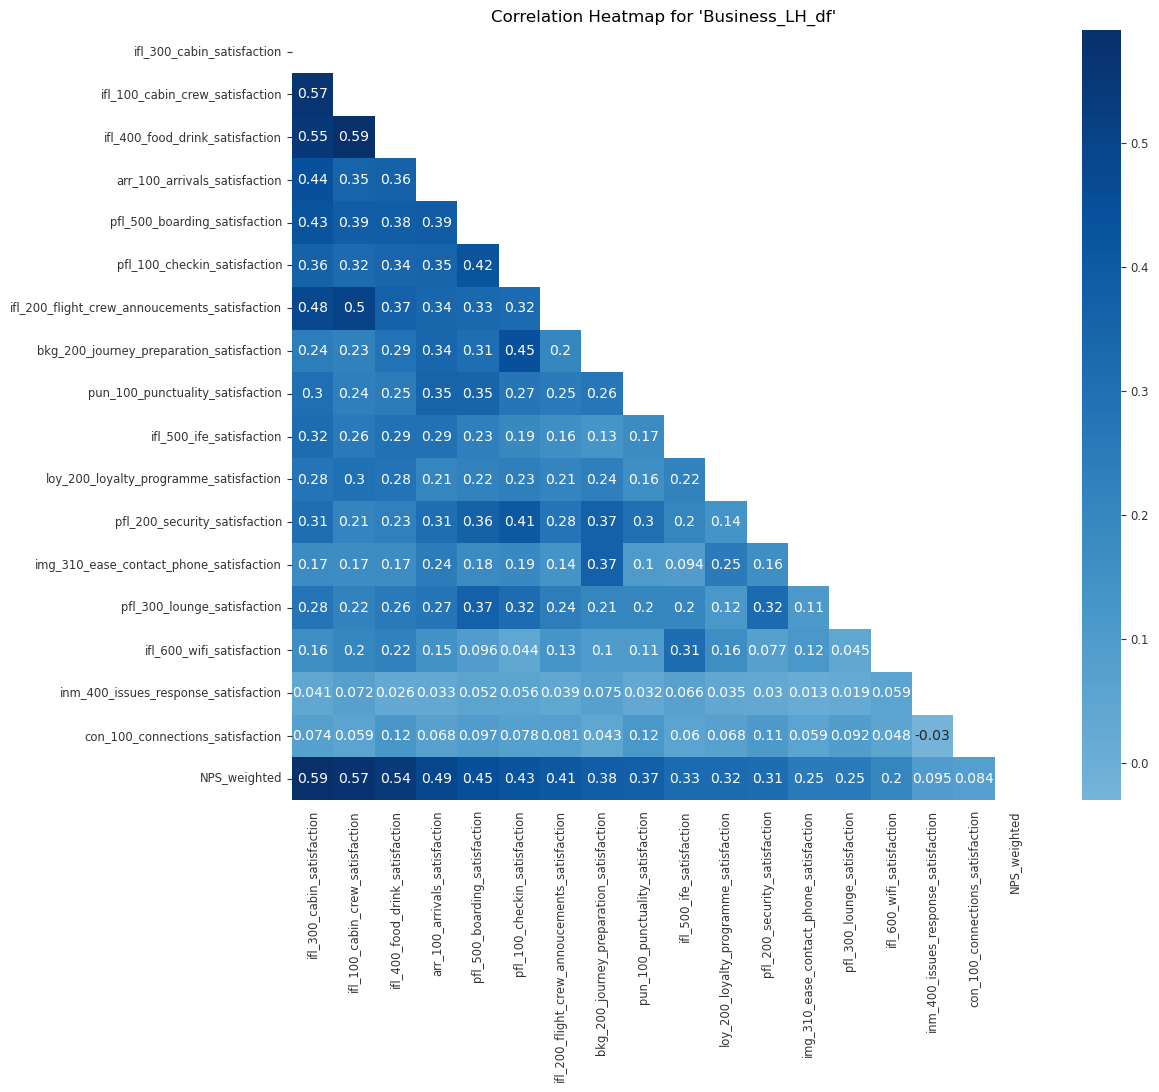

Top correlated features for 'Business_SH_df': ifl_300_cabin_satisfaction, pfl_100_checkin_satisfaction, pfl_500_boarding_satisfaction, ifl_400_food_drink_satisfaction, arr_100_arrivals_satisfaction, ifl_100_cabin_crew_satisfaction, pun_100_punctuality_satisfaction, bkg_200_journey_preparation_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, pfl_200_security_satisfaction, img_310_ease_contact_phone_satisfaction, loy_200_loyalty_programme_satisfaction, pfl_300_lounge_satisfaction, con_100_connections_satisfaction, ifl_600_wifi_satisfaction, inm_400_issues_response_satisfaction, ifl_500_ife_satisfaction


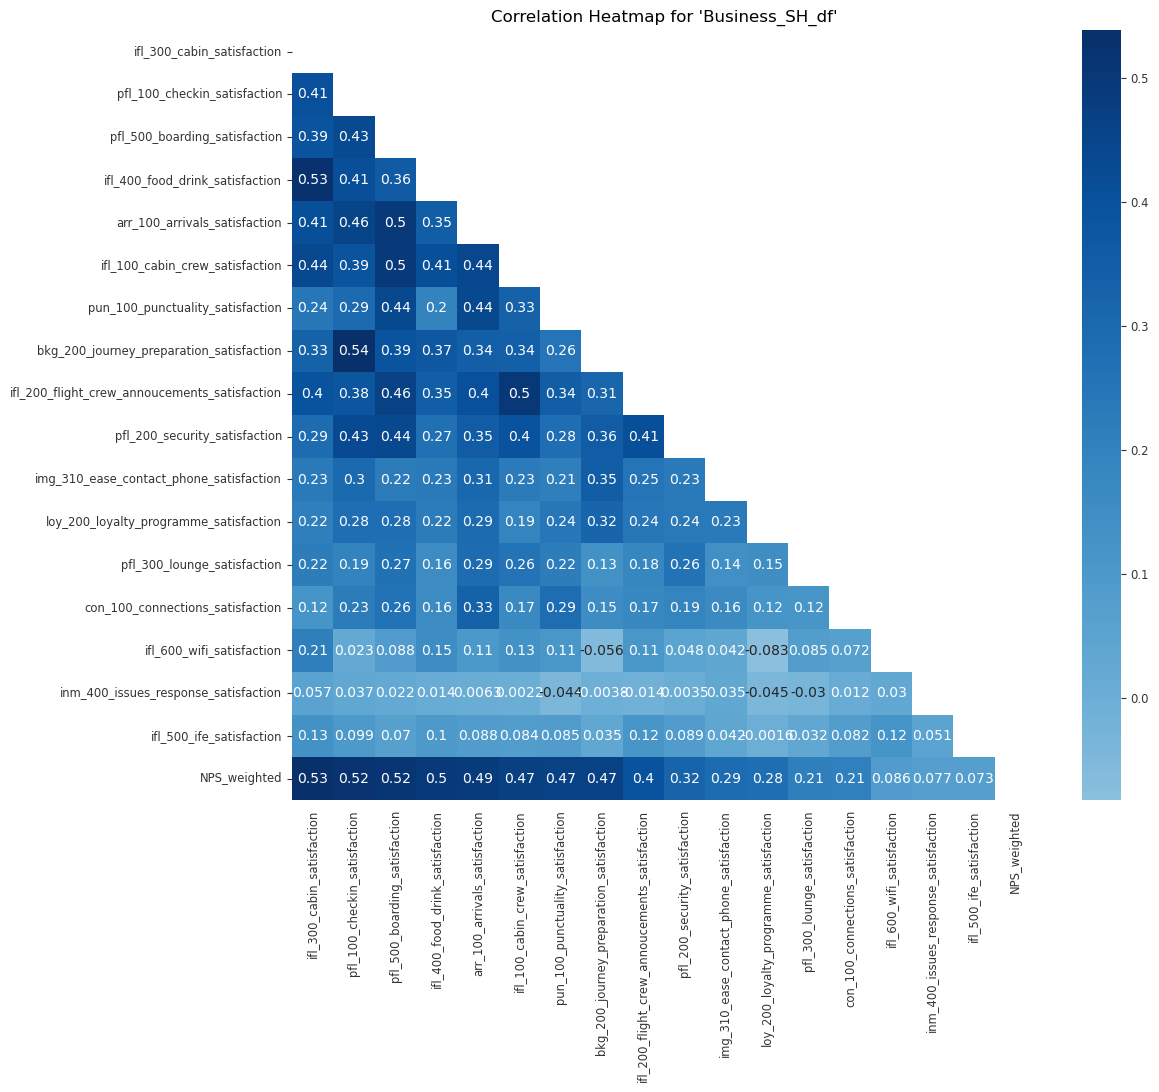

Top correlated features for 'Economy_LH_df': ifl_100_cabin_crew_satisfaction, pfl_100_checkin_satisfaction, ifl_300_cabin_satisfaction, bkg_200_journey_preparation_satisfaction, arr_100_arrivals_satisfaction, ifl_400_food_drink_satisfaction, pfl_500_boarding_satisfaction, pun_100_punctuality_satisfaction, pfl_200_security_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, img_310_ease_contact_phone_satisfaction, loy_200_loyalty_programme_satisfaction, con_100_connections_satisfaction, ifl_500_ife_satisfaction, inm_400_issues_response_satisfaction, pfl_300_lounge_satisfaction, ifl_600_wifi_satisfaction


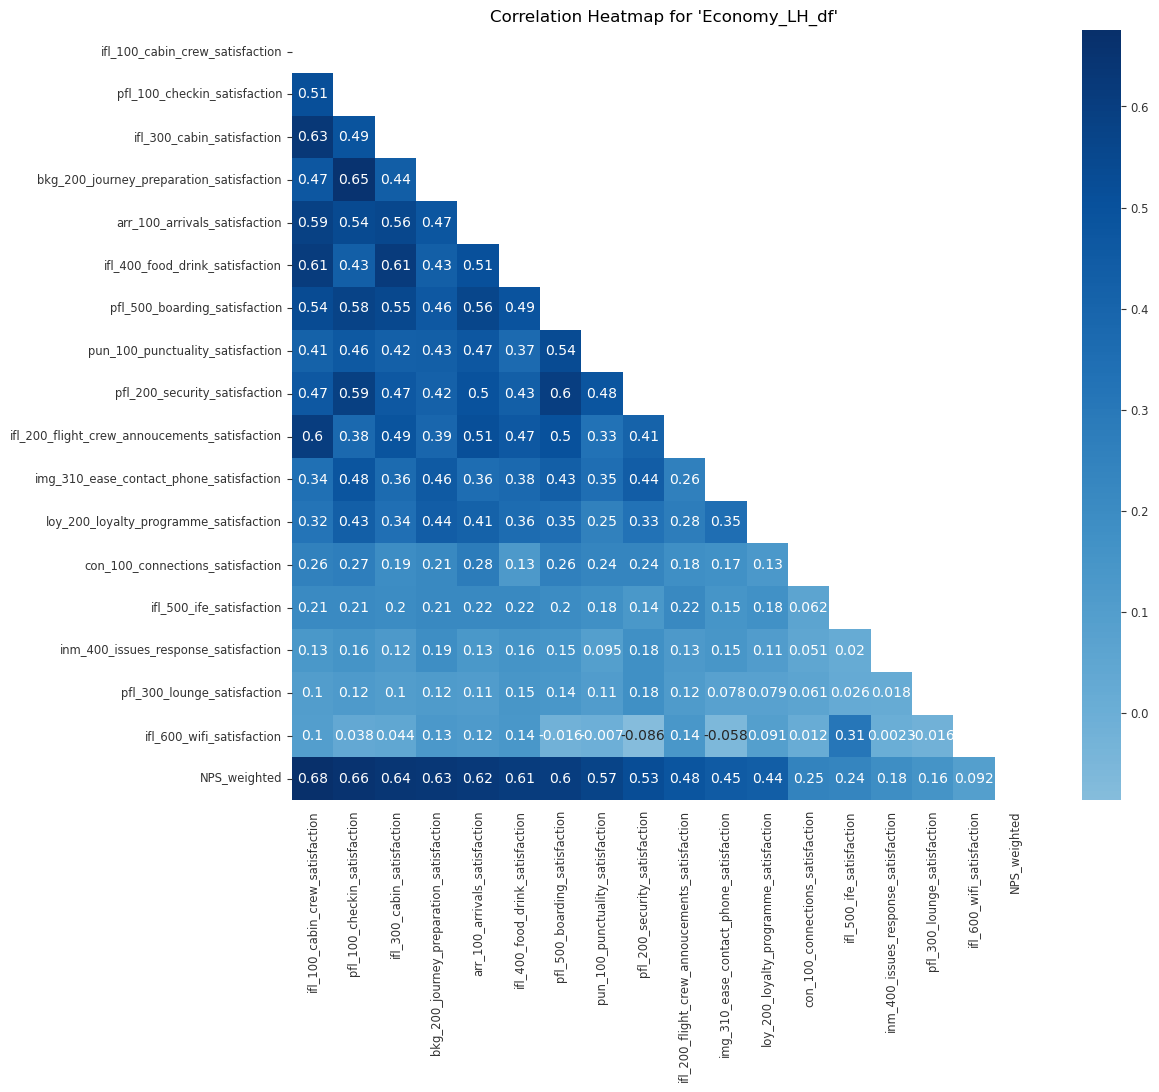

Top correlated features for 'Economy_SH_df': pun_100_punctuality_satisfaction, pfl_500_boarding_satisfaction, ifl_100_cabin_crew_satisfaction, arr_100_arrivals_satisfaction, pfl_100_checkin_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, ifl_300_cabin_satisfaction, pfl_200_security_satisfaction, bkg_200_journey_preparation_satisfaction, ifl_400_food_drink_satisfaction, img_310_ease_contact_phone_satisfaction, con_100_connections_satisfaction, loy_200_loyalty_programme_satisfaction, inm_400_issues_response_satisfaction, ifl_600_wifi_satisfaction, pfl_300_lounge_satisfaction, ifl_500_ife_satisfaction


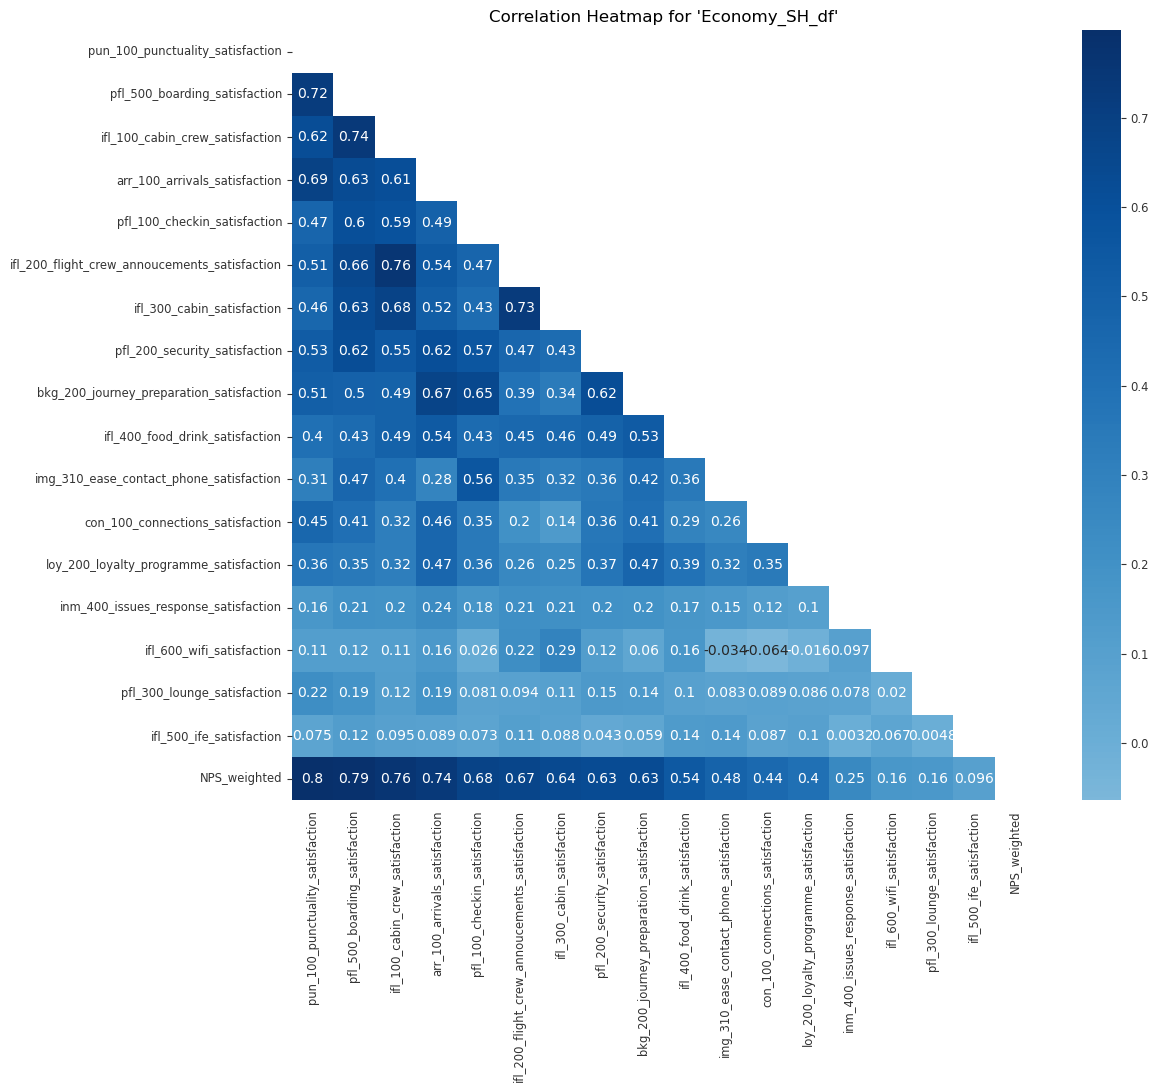

Top correlated features for 'Premium Economy_LH_df': ifl_100_cabin_crew_satisfaction, ifl_300_cabin_satisfaction, ifl_400_food_drink_satisfaction, pfl_100_checkin_satisfaction, pfl_500_boarding_satisfaction, bkg_200_journey_preparation_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, arr_100_arrivals_satisfaction, pun_100_punctuality_satisfaction, loy_200_loyalty_programme_satisfaction, pfl_200_security_satisfaction, ifl_500_ife_satisfaction, img_310_ease_contact_phone_satisfaction, con_100_connections_satisfaction, ifl_600_wifi_satisfaction, pfl_300_lounge_satisfaction, inm_400_issues_response_satisfaction


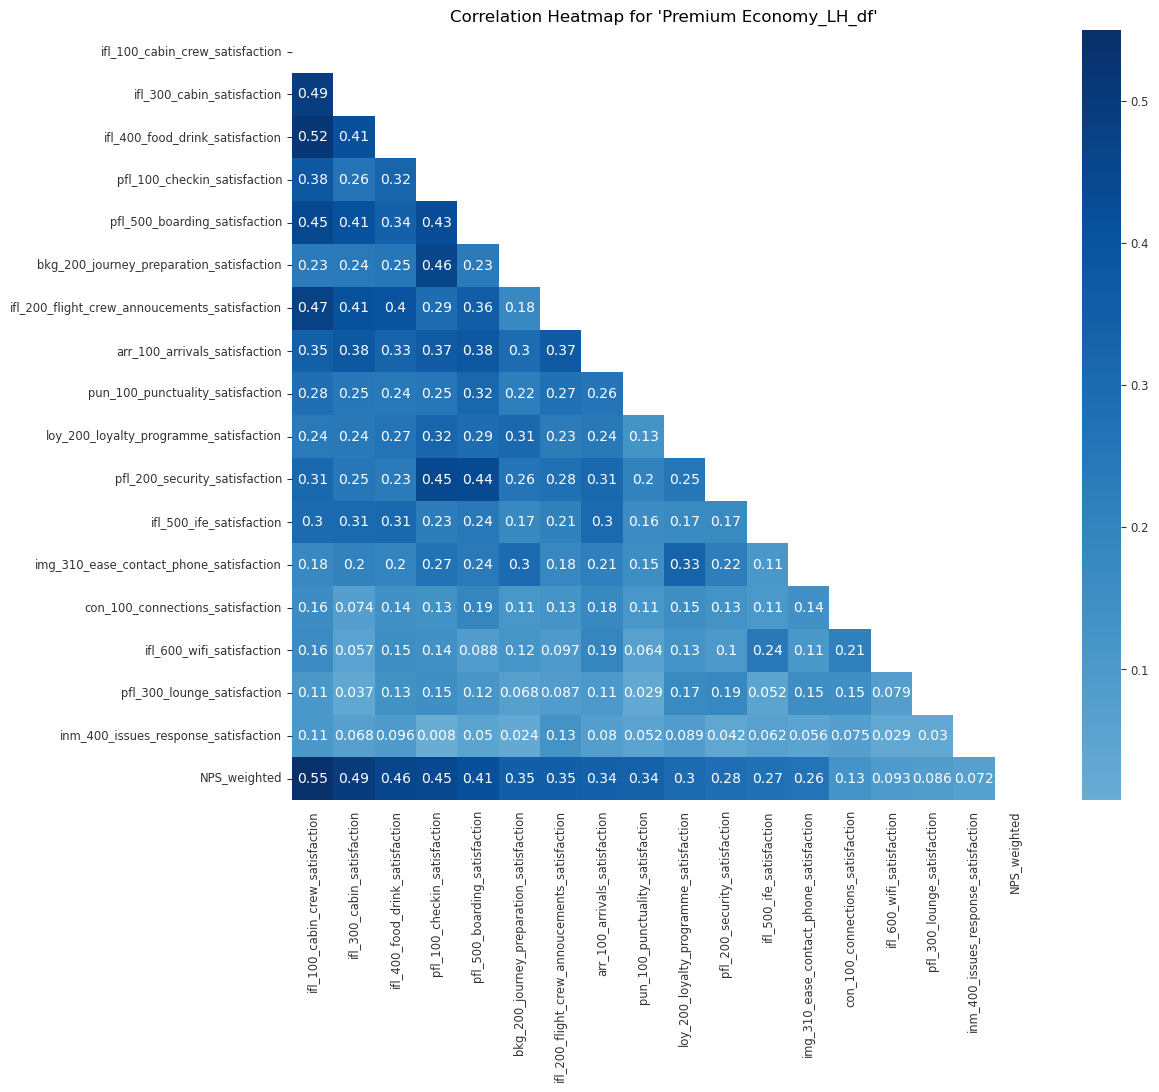

In [21]:
def get_top_correlated_features(df, n):
    # Select only the float columns from the DataFrame
    float_columns = df.select_dtypes(include=['float64'])

    # Calculate the correlation matrix for the float columns
    correlation_matrix = float_columns.corr()

    # Get the correlation values of each feature with NPS and sort them by absolute values in descending order
    nps_correlations = correlation_matrix['NPS_weighted'].drop('NPS_weighted').abs().sort_values(ascending=False)

    # Get the top 'n' features with the highest correlations among float features
    top_n_correlated_features = nps_correlations.nlargest(n).index.tolist()
    
    # Create a subset of the correlation matrix with only the top correlated features and NPS
    correlation_matrix_subset = correlation_matrix.loc[top_n_correlated_features + ['NPS_weighted'], top_n_correlated_features + ['NPS_weighted']]

    return top_n_correlated_features, correlation_matrix_subset


for df_id, value in grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    top_correlated_features, correlation_matrix = get_top_correlated_features(value[[col for col in value.columns if col.endswith('_satisfaction')]+ ['NPS_weighted']], 17)
    
    # Print the top correlated features
    print(f"Top correlated features for '{df_id}': {', '.join(top_correlated_features)}")
    
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, mask=mask)
    plt.title(f"Correlation Heatmap for '{df_id}'")
    plt.show()



### Clusteres

#### Manual

In [22]:
feature_clusters={}
for key in grouped_dfs.keys():
    feature_clusters[key]= {'pre_post_travel': ['bkg_200_journey_preparation_satisfaction','pfl_100_checkin_satisfaction','img_310_ease_contact_phone_satisfaction','inm_400_issues_response_satisfaction'], 'staff': ['ifl_100_cabin_crew_satisfaction','ifl_200_flight_crew_annoucements_satisfaction'], 'time_related': ['pun_100_punctuality_satisfaction','con_100_connections_satisfaction','arr_100_arrivals_satisfaction'], 'airplane_comodities': ['ifl_500_ife_satisfaction','ifl_300_cabin_satisfaction','ifl_400_food_drink_satisfaction', 'ifl_600_wifi_satisfaction'],'preferential_treatment':['loy_200_loyalty_programme_satisfaction','pfl_300_lounge_satisfaction'], "waiting_times": ['pfl_200_security_satisfaction', 'pfl_500_boarding_satisfaction','pfl_100_checkin_satisfaction'], }

#### Agglomerative Clustering

#### K-means

### PCA in clusters

### Feature selection based on Pearson

### Feature selection based on VIF

In [23]:
[col for col in merged_df.columns if col.startswith('otp15')]

['otp15_landing', 'otp15_takeoff']

### Sporiously correlated touchpoints (common cofounders)

In [24]:
[col for col in merged_df.columns if col.endswith('satisfaction')]

['bkg_200_journey_preparation_satisfaction',
 'pfl_100_checkin_satisfaction',
 'pfl_200_security_satisfaction',
 'pfl_300_lounge_satisfaction',
 'pfl_500_boarding_satisfaction',
 'ifl_300_cabin_satisfaction',
 'ifl_200_flight_crew_annoucements_satisfaction',
 'ifl_600_wifi_satisfaction',
 'ifl_500_ife_satisfaction',
 'ifl_400_food_drink_satisfaction',
 'ifl_100_cabin_crew_satisfaction',
 'arr_100_arrivals_satisfaction',
 'con_100_connections_satisfaction',
 'pun_100_punctuality_satisfaction',
 'loy_200_loyalty_programme_satisfaction',
 'inm_400_issues_response_satisfaction',
 'img_310_ease_contact_phone_satisfaction']

### Select features to train with

So we have that all cabin/haul top_5 correlated touchpoints are the same, although not equally sorted. let us filter our dataframe by those touchpoints:

In [25]:

# Create the output directory if it doesn't exist
df_dir = "dataframes_Adjusted_NPS"
if not os.path.exists(df_dir):
    os.makedirs(df_dir)

#### All touchpoints and variables

#### Just all touchpoints

In [26]:
features={}
for df_id, df in grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in merged_df.columns if col.endswith('_satisfaction')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    df.to_csv(f'{df_dir}/Adjusted_NPS_{df_id}', index=False)
    grouped_dfs[df_id]=df

#### Top importance for business touchpoints and all variables

#### Just top importance for business touchpoints

#### Top_5_tp and all variables

Lets check the time dependencies of these features:

#### PCA components

Therefore, the variables to lag are going to be:

1) Business_LH: [load_factor, mean_price] + [col for col in df.columns if col.startswith('otp')]
2) Business_SH: [load_factor, mean_price, deviation_price] + [col for col in df.columns if col.startswith('otp')]
3) Economy_LH: [load_factor, mean_price, deviation_price] + [col for col in df.columns if col.startswith('otp')]
4) Economy_SH: [pun_100_punctuality_satisfaction, load_factor, mean_price, deviation_price] + [col for col in df.columns if col.startswith('otp')]


In [27]:
# Dictionary to store lag variables for each DataFrame
lag_features = {
    'Economy_LH_df': [],
    'Economy_SH_df': [],
    #'pun_100_punctuality_satisfaction', + [col for col in merged_df.columns if col.startswith('otp15')],
    #'Business_LH_df': ['load_factor', 'mean_price', 'deviation_price', 'otp3_takeoff', 'otp14_takeoff', 'otp15_takeoff'],
    'Business_LH_df': [],
    #,  'otp15_takeoff'],
    'Business_SH_df': [],
    #+ [col for col in merged_df.columns if col.startswith('otp15')],
    'Premium Economy_LH_df': []
}

One thing we can also notice is how March 2023 is deeply affected by the strikes that took place during that month. Until we get more variables lets smooth out that month a bit by taking the mean value (for each variable) of 2019 and 2022.

In [28]:
grouped_dfs['Premium Economy_LH_df'].describe()

bkg_200_journey_preparation_satisfaction  pfl_100_checkin_satisfaction  \
count                                960.000000                    960.000000   
mean                                  65.208396                     73.097511   
std                                   21.979380                     19.258863   
min                                    0.000000                      0.000000   
25%                                   50.000000                     62.500000   
50%                                   66.666667                     75.000000   
75%                                   80.000000                     85.714286   
max                                  100.000000                    100.000000   

       pfl_200_security_satisfaction  pfl_300_lounge_satisfaction  \
count                     960.000000                   960.000000   
mean                       76.710925                    58.190724   
std                        19.736479                    42.691104   
min                         0.000000                     0.000000   
25%                        66.666667                     0.000000   
50%                        80.000000                    66.666667   
75%                        90.000000                   100.000000   
max                       100.000000                   100.000000   

       pfl_500_boarding_satisfaction  ifl_300_cabin_satisfaction  \
count                     960.000000                  960.000000   
mean                       73.186331                   72.902890   
std                        19.137519                   19.017985   
min                         0.000000                    0.000000   
25%                        62.500000                   63.516746   
50%                        75.000000                   75.000000   
75%                        85.714286                   85.714286   
max                       100.000000                  100.000000   

       ifl_200_flight_crew_annoucements_satisfaction  \
count                                     960.000000   
mean                                       76.217645   
std                                        18.496169   
min                                         0.000000   
25%                                        66.666667   
50%                                        78.571429   
75%                                        88.888889   
max                                       100.000000   

       ifl_600_wifi_satisfaction  ifl_500_ife_satisfaction  \
count                 960.000000                960.000000   
mean                   26.510522                 68.709741   
std                    33.537275                 28.184861   
min                     0.000000                  0.000000   
25%                     0.000000                 57.142857   
50%                     0.000000                 74.342105   
75%                    50.000000                 90.000000   
max                   100.000000                100.000000   

       ifl_400_food_drink_satisfaction  ifl_100_cabin_crew_satisfaction  \
count                       960.000000                       960.000000   
mean                         49.103180                        70.317432   
std                          21.956613                        19.391810   
min                           0.000000                         0.000000   
25%                          34.803922                        60.000000   
50%                          50.000000                        71.428571   
75%                          63.636364                        83.333333   
max                         100.000000                       100.000000   

       arr_100_arrivals_satisfaction  con_100_connections_satisfaction  \
count                     960.000000                        960.000000   
mean                       72.833347                         45.236243   
std                        19.462166                         41.088911   
min   

# Adjusted NPS training

## Fill in  missing dates

In [29]:
def fill_missing_dates(df):
    # Create a date range covering the expected time period
    start_date = df['date_flight_local'].min()
    end_date = df['date_flight_local'].max()
    expected_dates = pd.date_range(start_date, end_date)

    # Reindex the DataFrame with the expected dates
    df = df.set_index('date_flight_local').reindex(expected_dates)

    # Use forward fill to fill missing values in other columns
    df.fillna(method='ffill', inplace=True)

    # Reset the index to have 'date_flight_local' as a regular column
    df.reset_index(inplace=True)
    
    # Rename the index column back to 'date_flight_local'
    df.rename(columns={'index': 'date_flight_local'}, inplace=True)

    return df

# Apply the fill_missing_dates function to each DataFrame in grouped_dfs.values()
for key, df in grouped_dfs.items():
    grouped_dfs[key] = fill_missing_dates(df)

In [30]:
grouped_dfs['Economy_LH_df']

date_flight_local    cabin haul  bkg_200_journey_preparation_satisfaction  \
0          2021-01-01  Economy   LH                                 89.711111   
1          2021-01-02  Economy   LH                                 58.863158   
2          2021-01-03  Economy   LH                                 61.664516   
3          2021-01-04  Economy   LH                                 51.426087   
4          2021-01-05  Economy   LH                                 61.175758   
..                ...      ...  ...                                       ...   
968        2023-08-27  Economy   LH                                 72.815534   
969        2023-08-28  Economy   LH                                 64.150943   
970        2023-08-29  Economy   LH                                 63.033175   
971        2023-08-30  Economy   LH                                 72.413793   
972        2023-08-31  Economy   LH                                 74.129353   

     pfl_100_checkin_satisfaction  pfl_200_security_satisfaction  \
0                       94.179487                      87.978378   
1                       68.363636                      88.669767   
2                       68.111111                      81.822222   
3                       69.500000                      81.600000   
4                       80.684211                      78.021053   
..                            ...                            ...   
968                     78.280543                      87.557604   
969                     75.770925                      83.035714   
970                     75.109170                      83.185841   
971                     72.800000                      85.080645   
972                     81.308411                      86.729858   

     pfl_300_lounge_satisfaction  pfl_500_boarding_satisfaction  \
0                       9.800000                      64.346154   
1                      76.466667                      76.409091   
2                      69.800000                      79.944444   
3                       9.800000                      66.500000   
4                      76.466667                      68.394737   
..                           ...                            ...   
968                    50.000000                      82.432432   
969                    80.000000                      80.519481   
970                    69.800000                      76.855895   
971                    75.000000                      79.446640   
972                   100.000000                      80.188679   

     ifl_300_cabin_satisfaction  \
0                     73.630769   
1                     62.177778   
2                     65.511111   
3                     56.400000   
4                     51.768421   
..                          ...   
968                   74.778761   
969                   68.103448   
970                   68.669528   
971                   72.549020   
972                   71.028037   

     ifl_200_flight_crew_annoucements_satisfaction  ...  \
0                                        75.294872  ...   
1                                        74.611111  ...   
2                                        86.357143  ...   
3                                        67.500000  ...   
4                                        68.364865  ...   
..                                             ...  ...   
968                                      86.098655  ...   
969                                      82.894737  ...   
970                                      86.637931  ...   
971                                      83.858268  ...   
972                                      88.679245  ...   

     ifl_500_ife_satisfaction  ifl_400_food_drink_satisfaction  \
0                   68.511111                        57.317949   
1                   81.084211                        37.488889   
2                   77.400000                        60.028571   
3              

## Experiments

In [31]:
models = ['RandomForest']
add_encoders = {
    'cyclic': {'future': ['month']},
    'transformer': Scaler()
}
model_params = [    

    # Temporal lags for NPS and covariates
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6], "output_chunk_length": 1},
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1, -3, -6], "output_chunk_length": 1},
    #{"lags": 12, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], "output_chunk_length": 6},
    #{"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1,-2,-3,-4,-5,-6], "output_chunk_length": 6},
    #{"lags": 12, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 6},
    #{"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1, -3, -6], "output_chunk_length": 6},
    
    # Temporal lags for the NPS alone.
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    #{"lags": 12, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1], "output_chunk_length": 6},
    #{"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1], "output_chunk_length": 6},
    #{"lags": 12, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1], "output_chunk_length": 6},
    #{"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1], "output_chunk_length": 6},    
    
    
    # Temporal lags for the covariates alone.
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -3, -6], "output_chunk_length": 1},
    #{"lags": 1, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], "output_chunk_length": 6},
    #{"lags": 1, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1,-2,-3,-4,-5,-6], "output_chunk_length": 6},
    #{"lags": 1, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 6},
    #{"lags": 1, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-1, -3, -6], "output_chunk_length": 6},    
    
    
    # Almost Non temporal lags. 
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    #{"lags": 1, "lags_future_covariates": [0,1], "lags_past_covariates": [-1], "output_chunk_length": 2},
    #{"lags": 1, "lags_future_covariates": [0,1,2], "lags_past_covariates": [-1], "output_chunk_length": 3},
    #{"lags": 1, "lags_future_covariates": [0,1,2,3,4,5], "lags_past_covariates": [-1], "output_chunk_length": 6},
    
    # Non temporal lags. 
    {"lags_future_covariates": [0], "output_chunk_length": 1},
    #{"lags_future_covariates": [0,1], "output_chunk_length": 2},
    #{"lags_future_covariates": [0,1,2], "output_chunk_length": 3},
    #{"lags_future_covariates": [0,1,2,3,4,5], "output_chunk_length": 6},
    
]

output_dir = "forecast_plots_Adjusted_NPS"

In [32]:
model_params = [    
    # Non temporal lags. 
    {"lags_future_covariates": [0], "output_chunk_length": 1}    
]


In [33]:
import os

# Create the output directory if it doesn't exist
output_dir = "forecast_plots_Adjusted_NPS"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Create the output directory if it doesn't exist
models_dir = "best_models_Adjusted_NPS"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

### TRAIN AND VAL DAILY GRANULARITY

### TRAIN WITH DAILY GRANULARITY AND VAL WITH MONTHLY

In [34]:
monthly_df=pd.read_csv('monthly_NPS_5ch_Touchpoints_adjusted_complete')

In [35]:
monthly_grouped_dfs = {}

# Group the original DataFrame by the 'cabin' and 'haul' columns
monthly_grouped = monthly_df.groupby(['cabin', 'haul'])

# Iterate through each group and create a DataFrame
for group_name, group_data in monthly_grouped:
    cabin_value, haul_value = group_name
    group_df = group_data.copy()  # Create a copy of the group's data
    group_df_name = f'{cabin_value}_{haul_value}_df'  # Generate a unique name
    monthly_grouped_dfs[group_df_name] = group_df
    
for key in grouped_dfs.keys():
    df = monthly_grouped_dfs[key]  # Access the DataFrame using the key
    
    df['date_flight_local']=pd.to_datetime(df['date_flight_local'])
    
    df = df[df['date_flight_local'].dt.year.isin([2019, 2022, 2023])]
    
    df['date_flight_local'] = df['date_flight_local'].apply(lambda x: x.replace(year=2021) if x.year == 2019 else x)
    
    df = df.reset_index(drop=True)
    
    monthly_grouped_dfs[key] = df# Replace the grouped DataFrames with the original merged_df DataFrame
monthly_df = pd.concat(monthly_grouped_dfs.values())

# Reset the index
monthly_df.reset_index(drop=True, inplace=True)

monthly_df.head()

date_flight_local  year  month     cabin haul        NPS  promoters_weight  \
0        2021-01-31  2019      1  Business   LH  42.222786        121.665838   
1        2021-02-28  2019      2  Business   LH  40.075400        113.669117   
2        2021-03-31  2019      3  Business   LH  39.648252        135.857876   
3        2021-04-30  2019      4  Business   LH  31.650138        128.308856   
4        2021-05-31  2019      5  Business   LH  46.491257        164.737385   

   detractors_weight  monthly_weight  NPS_weighted  ...  mean_price  \
0          25.560050      195.789983     42.222786  ...      976.46   
1          26.158165      186.436376     40.075400  ...     1060.33   
2          30.774436      225.929396     39.648252  ...     1161.61   
3          41.757320      224.730304     31.650138  ...     1073.66   
4          30.536686      251.525861     46.491257  ...     1170.74   

   deviation_price  otp3_landing  otp14_landing  otp15_landing  otp60_landing  \
0       901.539620     63.265306      76.530612      77.551020      97.959184   
1       932.449649     61.640798      78.713969      80.413895      98.078344   
2       979.200983     64.638783      79.277567      80.798479      96.641318   
3       936.824143     58.622829      75.682382      76.674938      96.712159   
4       994.345020     67.111369      80.916473      81.844548      96.461717   

   otp3_takeoff  otp14_takeoff  otp15_takeoff  otp60_takeoff  
0     56.122449      76.530612      80.612245      97.959184  
1     69.179601      87.804878      89.430894      98.373984  
2     68.757921      84.410646      85.868188      97.084918  
3     62.965261      83.560794      85.669975      96.650124  
4     69.083527      84.222738      86.948956      96.171694  

[5 rows x 109 columns]

In [36]:
for key, df in monthly_grouped_dfs.items():
    # Convert the "date_flight_local" column to datetime format
    df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
    
    # Get the list of numerical variables
    numerical_variables = df.select_dtypes(include=['float']).columns
    
    for variable in numerical_variables:
        # Filter rows for March 2019 and March 2022
        march_2019_value = df[(df['date_flight_local'].dt.year == 2021) & (df['date_flight_local'].dt.month == 3)][variable].values[0]
        march_2022_value = df[(df['date_flight_local'].dt.year == 2022) & (df['date_flight_local'].dt.month == 3)][variable].values[0]
        
        # Compute the mean for March 2023
        march_2023_smoothed = (march_2019_value + march_2022_value) / 2
        
        # Update the value for March 2023 in the dataframe
        df.loc[(df['date_flight_local'].dt.year == 2023) & (df['date_flight_local'].dt.month == 3), variable] = march_2023_smoothed

#### Just top touchpoints for bussines

#### Just all tocuhpoints

In [37]:
features={}
for df_id, df in monthly_grouped_dfs.items():
    # Get the top correlated features and the correlation matrix for this DataFrame
    features[df_id]=[col for col in merged_df.columns if col.endswith('_satisfaction')]
    # Define the columns to keep in the desired order
    cols_to_keep = ['date_flight_local', 'cabin', 'haul'] + features[df_id] + ['NPS_weighted']
    # Keep only the specified columns in the desired order
    df = df[cols_to_keep]
    df.to_csv(f'{df_dir}/Adjusted_NPS_{df_id}', index=False)
    monthly_grouped_dfs[df_id]=df

In [38]:
def count_missing_dates(df):
    # Create a date range covering the expected time period
    start_date = df['date_flight_local'].min()
    end_date = df['date_flight_local'].max()    
    expected_dates = pd.date_range(start_date, end_date)
    # Calculate missing dates
    missing_dates = expected_dates[~expected_dates.isin(df['date_flight_local'])]

    # Count the number of missing dates
    missing_dates_count = len(missing_dates)

    return missing_dates_count

# Create a dictionary to store the missing date counts for each DataFrame
missing_dates_counts = {}

# Calculate missing date counts for each DataFrame in grouped_dfs
for key, df in grouped_dfs.items():
    missing_dates_counts[key] = count_missing_dates(df)

### Using Random Forest

In [39]:
def train_and_save_best_mae_models(models, model_params_list, grouped_dfs, monthly_grouped_dfs, output_dir, model_save_dir):
    best_models_by_dataframe = {}
    
    start_date = pd.to_datetime('2023-09-30')
    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    pred_ts_dict= {}
    future_scaler_dict={}
    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df=grouped_dfs[key]
                df['date_flight_local'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date_flight_local')
                df = df.fillna(0)
                
                pred_df=monthly_grouped_dfs[key]
                pred_df['date_flight_local'] = pd.to_datetime(pred_df['date_flight_local'])
                pred_df = pred_df.set_index('date_flight_local')
                pred_df = pred_df.fillna(0)
                
                
                
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='D') 
                past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='D')
                future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='D') 
                
                pred_ts_dict[key] = TimeSeries.from_series(pred_df['NPS_weighted'], freq='M') 
                pred_past_covariates_ts = TimeSeries.from_series(pred_df[lag_features[key]], freq='M')
                pred_future_covariates_ts = TimeSeries.from_series(pred_df[features[key]], freq='M') 
                
                
                # past_scaler = Scaler()
                # past_scaler.fit(past_covariates_ts)
                # train_past_covariates_ts_scaled = past_scaler.transform(past_covariates_ts) 
                
                future_scaler = Scaler()
                future_scaler.fit(future_covariates_ts)
                future_scaler_dict[key]=future_scaler
                train_future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)                
                pred_future_covariates_ts_scaled = future_scaler.transform(pred_future_covariates_ts)

                if model_name == 'LightGBMModel':
                    model = LightGBMModel(**model_params)
                elif model_name == 'RandomForest':
                    model = RandomForest(**model_params)
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")
                
                if "lags_past_covariates" in model_params.keys():
                    model.fit(nps_ts_dict[key], future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                    pred_series = model.predict(n=180, series=train_ts, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                else:
                    model.fit(nps_ts_dict[key], future_covariates=train_future_covariates_ts_scaled)
                    pred_series = model.predict(n=31, series= pred_ts_dict[key][:1], future_covariates=pred_future_covariates_ts_scaled)
                    
                #pred_series = nps_scaler.inverse_transform(pred_series_scaled)
                mae = mean_absolute_error(pred_ts_dict[key][1:].values(), pred_series.values())
                mape = mean_absolute_percentage_error(pred_ts_dict[key][1:].values(), pred_series.values())

                if key not in best_models_by_dataframe or mae < best_models_by_dataframe[key]['mae']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'params': model_params,
                        'pred_series': pred_series,
                        'model': model  # Save the model instance in the dictionary
                    }

    # Save the best models after all loops
    for df_id, value in best_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir, f"best_mae_model_{df_id}_{value['model_name']}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        pred_ts_dict[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mae - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_{df_id}_mae_{value['model_name']}.png")
        plt.close()

    return best_models_by_dataframe, nps_ts_dict, pred_ts_dict, future_scaler_dict

# Assuming you have the grouped_dfs dictionary defined
best_mae_models_by_dataframe, nps_ts_dict_mae, pred_ts_dict_mae, future_scaler_dict_mae = train_and_save_best_mae_models(models, model_params, grouped_dfs, monthly_grouped_dfs, output_dir, models_dir)

### Using different regressors from RegressionModel()

### Evaluation

In [40]:
# Print the best models for each dataframe
for df_id, value in best_mae_models_by_dataframe.items():
    print(f"Best Mae Model for DataFrame '{df_id}':")
    print("Model Name:", value['model_name'])
    print("MAE:", format(value['mae'], '.3f'))
    print("MAPE:", format(value['mape'], '.3f'))
    print("Params:", value['params'])
    print()


Best Mae Model for DataFrame 'Business_LH_df':
Model Name: RandomForest
MAE: 3.701
MAPE: 0.101
Params: {'lags_future_covariates': [0], 'output_chunk_length': 1}

Best Mae Model for DataFrame 'Business_SH_df':
Model Name: RandomForest
MAE: 3.528
MAPE: 0.103
Params: {'lags_future_covariates': [0], 'output_chunk_length': 1}

Best Mae Model for DataFrame 'Economy_LH_df':
Model Name: RandomForest
MAE: 1.865
MAPE: 0.125
Params: {'lags_future_covariates': [0], 'output_chunk_length': 1}

Best Mae Model for DataFrame 'Economy_SH_df':
Model Name: RandomForest
MAE: 1.231
MAPE: 0.050
Params: {'lags_future_covariates': [0], 'output_chunk_length': 1}

Best Mae Model for DataFrame 'Premium Economy_LH_df':
Model Name: RandomForest
MAE: 5.301
MAPE: 0.171
Params: {'lags_future_covariates': [0], 'output_chunk_length': 1}



In [41]:
# Print the best models for each dataframe
#for df_id, value in best_mape_models_by_dataframe.items():
    #print(f"Best Mape Model for DataFrame '{df_id}':")
    #print("Model Name:", value['model_name'])
    #print("MAE:", format(value['mae'], '.3f'))
    #print("MAPE:", format(value['mape'], '.3f'))
    #print("Params:", value['params'])
    #print()

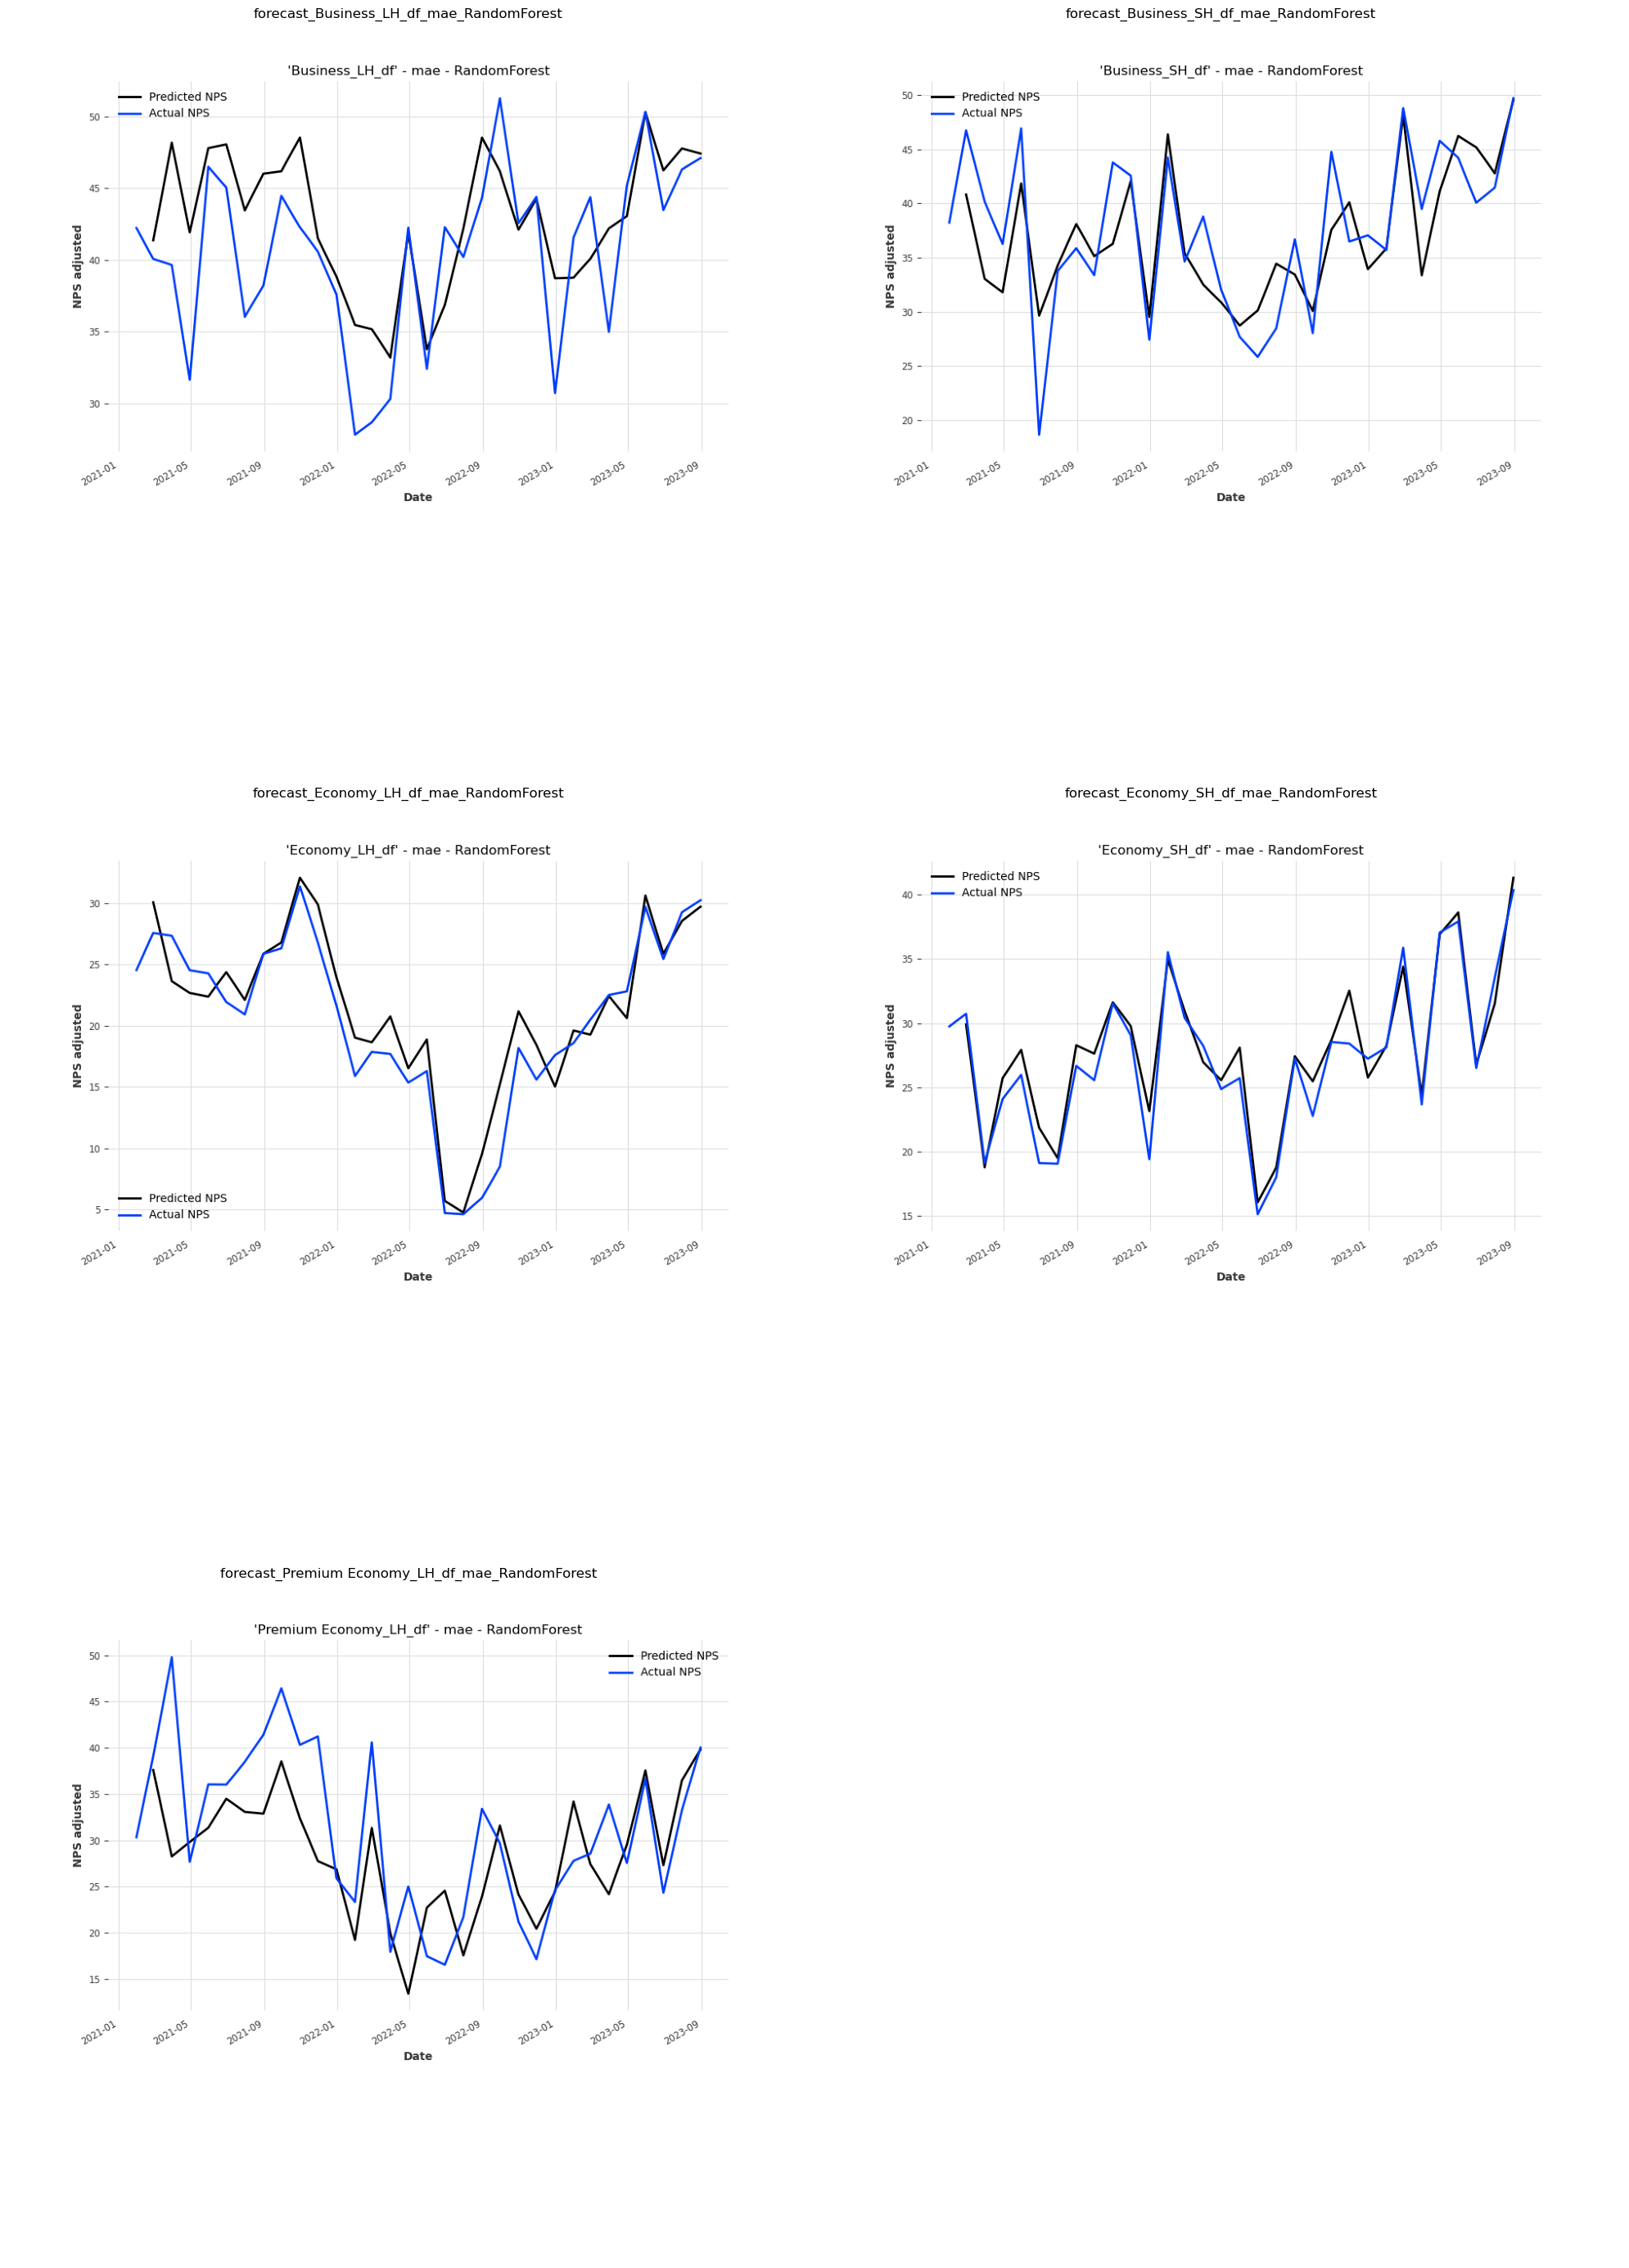

In [42]:
import os
import matplotlib.pyplot as plt

# Directory containing the forecast plots
forecast_plots_dir = "forecast_plots_Adjusted_NPS"

# List the files in the directory
forecast_plot_files = [f for f in os.listdir(forecast_plots_dir) if f.endswith(".png")]

# Sort the files to ensure consistent order
forecast_plot_files.sort()

# Calculate the number of rows and columns for subplots
num_plots = len(forecast_plot_files)
num_rows = (num_plots + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))

# Iterate through forecast plot files and display them as subplots
for i, filename in enumerate(forecast_plot_files):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    img = plt.imread(os.path.join(forecast_plots_dir, filename))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(filename[:-4])  # Remove ".png" from title

# Hide axis of the last subplot if it's empty
if num_plots % 2 == 1:
    axes[num_rows - 1, num_cols - 1].axis("off")

# Adjust layout
plt.tight_layout()


# Save the combined plot as a PNG file
combined_plot_filename = os.path.join(forecast_plots_dir, "All_Cabin_Hauls_Forecasts.png")
plt.savefig(combined_plot_filename)

# Show the subplots
plt.show()



# Backtest

# Shapley values

### Helpers

In [43]:
import shap
output_dir = "shapley_plots_Adjusted_NPS"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [44]:
shap.initjs()

In [45]:
# Create a dictionary with keys for each month from January 2019 to July 2023
months_dict = {
    '2019/01': 0, '2019/02': 1, '2019/03': 2, '2019/04': 3, '2019/05': 4, '2019/06': 5, '2019/07': 6,
    '2019/08': 7, '2019/09': 8, '2019/10': 9, '2019/11': 10, '2019/12': 11,
    '2022/01': 12, '2022/02': 13, '2022/03': 14, '2022/04': 15, '2022/05': 16, '2022/06': 17, '2022/07': 18,
    '2022/08': 19, '2022/09': 20, '2022/10': 21, '2022/11': 22, '2022/12': 23,
    '2023/01': 24, '2023/02': 25, '2023/03': 26, '2023/04': 27, '2023/05': 28, '2023/06': 29, '2023/07': 30
}

In [46]:
def create_difference_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the difference between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the difference.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation1.values - explanation2.values
    diff_base_values = explanation1.base_values - explanation2.base_values
    diff_data = explanation1.data - explanation2.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

### Caveats

1) Correlations among features, particularly temporal lags.
2) Shap fit over the whole dataset (including the validation values or the values at the time of prediction), or only on the trainning set.
3) 

## Single cabin/haul

### Business SH

In [47]:
key='Business_SH_df'
model_name=best_mae_models_by_dataframe[key]['model_name']
ts=pred_ts_dict_mae[key]
back_ts=nps_ts_dict_mae[key]
exp_df=monthly_grouped_dfs[key]
exp_df['date_flight_local'] = pd.to_datetime(exp_df['date_flight_local'])
exp_df = exp_df.set_index('date_flight_local')

#past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
future_covariates_ts = TimeSeries.from_series(exp_df[features[key]], freq='M')
                
future_scaler = future_scaler_dict_mae[key]
future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

# Load the pre-trained model
model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{key}_{model_name}.pkl")
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)
    
shap_explain = ShapExplainer(model=model)


In [48]:
shap_explained = shap_explain.explain(ts,foreground_future_covariates=future_covariates_ts_scaled)
explanation=shap_explained.get_shap_explanation_object(horizon=1)

if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    past_lags=best_mae_models_by_dataframe[key]['params']['lags_past_covariates']
future_lags=best_mae_models_by_dataframe[key]['params']['lags_future_covariates']

# Apply the transformation for each lag in past_lags
if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    for lag in past_lags:
        # Select columns for the current lag of past covariates
        current_past_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"pastcov_lag{lag}" in feature]
        # Select data for the current lag of past covariates
        data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]
    
        # Apply the transformation and store the result
        transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
        explanation.data[:, current_past_covariates_indices] = transformed_past_data

# Apply the transformation for each lag in future_lags
for lag in future_lags:
    # Select columns for the current lag of future covariates
    current_future_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"futcov_lag{lag}" in feature]
    
    # Select data for the current lag of future covariates
    data_for_current_future_covariates = explanation.data[:, current_future_covariates_indices]
    
    # Apply the transformation and store the result
    transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()
    
    explanation.data[:, current_future_covariates_indices] = transformed_future_data

Permutation explainer: 33it [00:22,  1.07s/it]                        


In [49]:
shap_explain.force_plot_from_ts(ts, foreground_future_covariates=future_covariates_ts_scaled)

Permutation explainer: 33it [00:19,  1.19s/it]                        


Top correlated features for 'Business_SH_df': ifl_300_cabin_satisfaction, pfl_100_checkin_satisfaction, pfl_500_boarding_satisfaction, ifl_400_food_drink_satisfaction, arr_100_arrivals_satisfaction, ifl_100_cabin_crew_satisfaction, pun_100_punctuality_satisfaction, bkg_200_journey_preparation_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, pfl_200_security_satisfaction, img_310_ease_contact_phone_satisfaction, loy_200_loyalty_programme_satisfaction, pfl_300_lounge_satisfaction, con_100_connections_satisfaction, ifl_600_wifi_satisfaction, inm_400_issues_response_satisfaction, ifl_500_ife_satisfaction


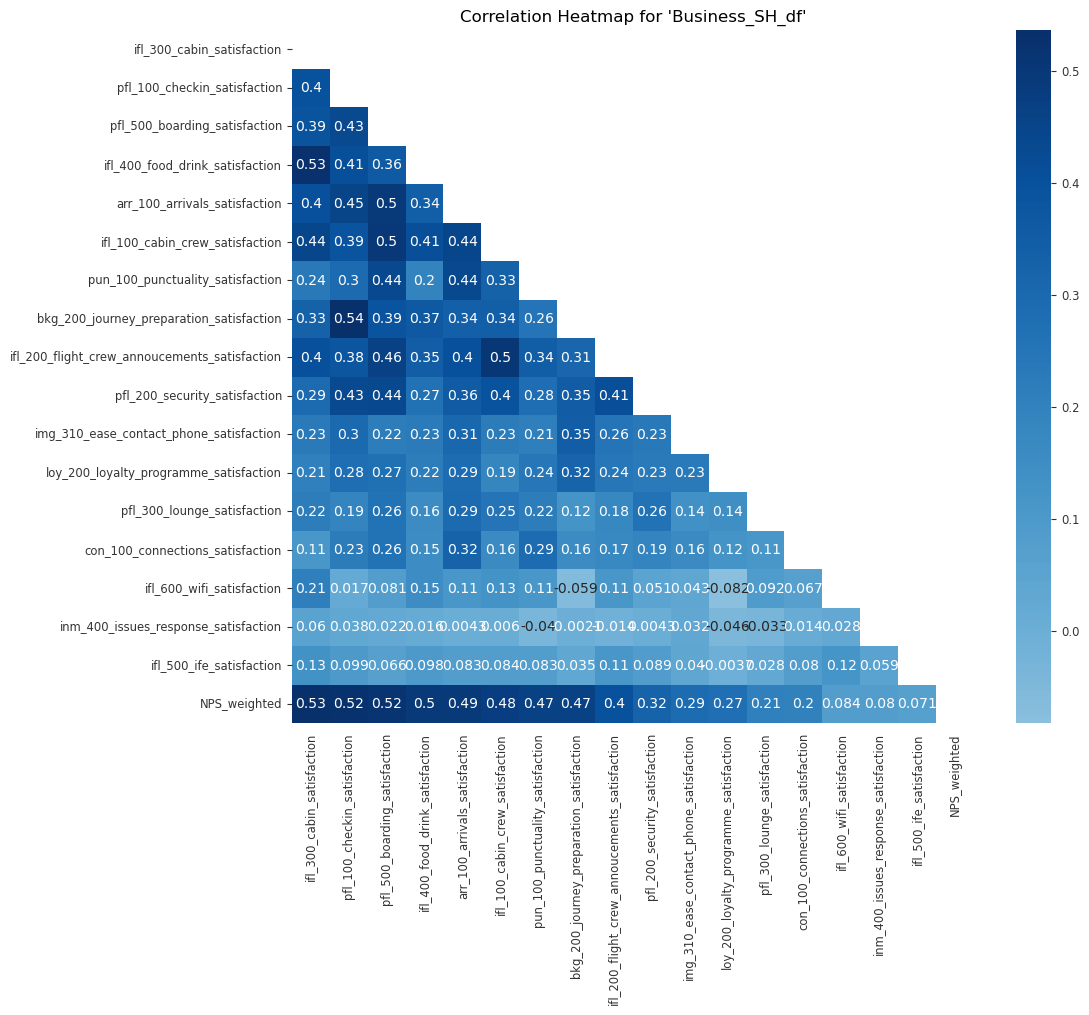

In [50]:
# Get the top correlated features and the correlation matrix for this DataFrame
top_correlated_features, correlation_matrix = get_top_correlated_features(grouped_dfs[key], 17)
    
# Print the top correlated features
print(f"Top correlated features for '{key}': {', '.join(top_correlated_features)}")
    
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, mask=mask)
plt.title(f"Correlation Heatmap for '{key}'")
plt.show()

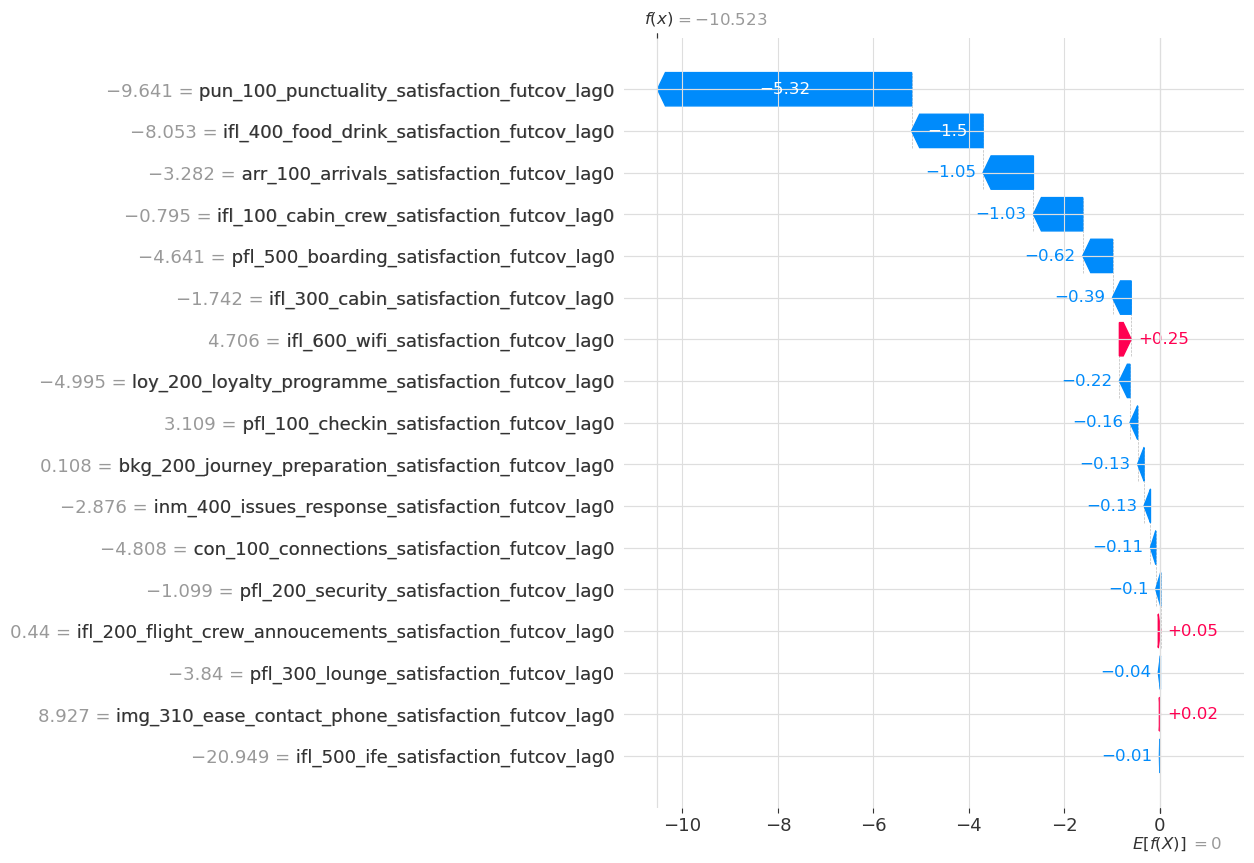

In [51]:
dif_exp=create_difference_explanation(explanation[months_dict['2022/01']],explanation[months_dict['2023/01']])
shap.plots.waterfall(shap_values=dif_exp, max_display=20)

### Business LH

In [52]:
key='Business_LH_df'
ts=pred_ts_dict_mae[key]
back_ts=nps_ts_dict_mae[key]
exp_df=monthly_grouped_dfs[key]
exp_df['date_flight_local'] = pd.to_datetime(exp_df['date_flight_local'])
exp_df = exp_df.set_index('date_flight_local')

#past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
future_covariates_ts = TimeSeries.from_series(exp_df[features[key]], freq='M')
                
future_scaler = future_scaler_dict_mae[key]
future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

# Load the pre-trained model
model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{key}_RandomForest.pkl")
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)
    
shap_explain = ShapExplainer(model=model)
shap_explained = shap_explain.explain(ts,foreground_future_covariates=future_covariates_ts_scaled)
explanation=shap_explained.get_shap_explanation_object(horizon=1)

if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    past_lags=best_mae_models_by_dataframe[key]['params']['lags_past_covariates']
future_lags=best_mae_models_by_dataframe[key]['params']['lags_future_covariates']

# Apply the transformation for each lag in past_lags
if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    for lag in past_lags:
        # Select columns for the current lag of past covariates
        current_past_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"pastcov_lag{lag}" in feature]
        # Select data for the current lag of past covariates
        data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]
    
        # Apply the transformation and store the result
        transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
        explanation.data[:, current_past_covariates_indices] = transformed_past_data

# Apply the transformation for each lag in future_lags
for lag in future_lags:
    # Select columns for the current lag of future covariates
    current_future_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"futcov_lag{lag}" in feature]
    
    # Select data for the current lag of future covariates
    data_for_current_future_covariates = explanation.data[:, current_future_covariates_indices]
    
    # Apply the transformation and store the result
    transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()
    
    explanation.data[:, current_future_covariates_indices] = transformed_future_data

Permutation explainer: 33it [00:19,  1.17s/it]                        


In [53]:
shap_explain.force_plot_from_ts(ts,foreground_future_covariates=future_covariates_ts_scaled)

Permutation explainer: 33it [00:18,  1.18s/it]                        


Top correlated features for 'Business_LH_df': ifl_300_cabin_satisfaction, ifl_100_cabin_crew_satisfaction, ifl_400_food_drink_satisfaction, arr_100_arrivals_satisfaction, pfl_500_boarding_satisfaction, pfl_100_checkin_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, bkg_200_journey_preparation_satisfaction, pun_100_punctuality_satisfaction, loy_200_loyalty_programme_satisfaction, ifl_500_ife_satisfaction, pfl_200_security_satisfaction, img_310_ease_contact_phone_satisfaction, pfl_300_lounge_satisfaction, ifl_600_wifi_satisfaction, inm_400_issues_response_satisfaction, con_100_connections_satisfaction


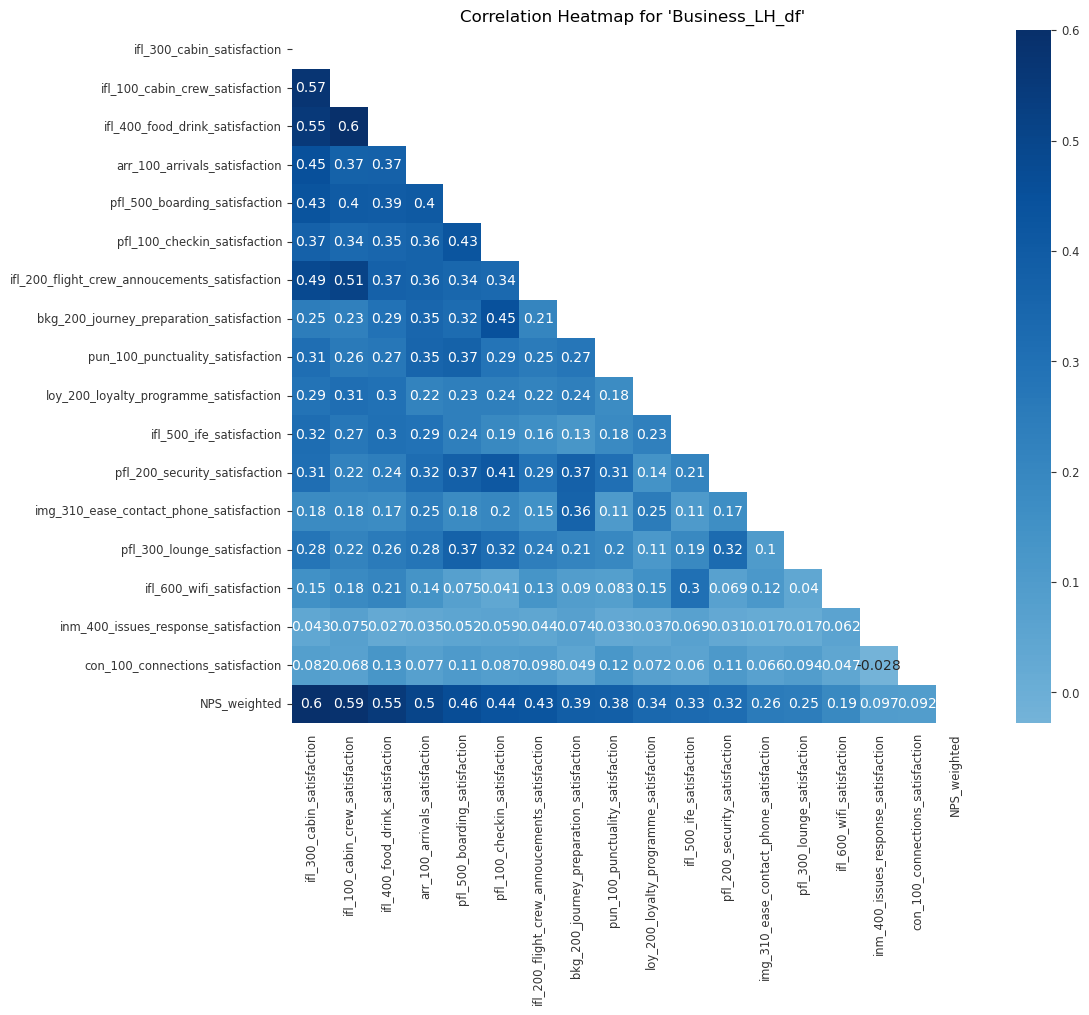

In [54]:
# Get the top correlated features and the correlation matrix for this DataFrame
top_correlated_features, correlation_matrix = get_top_correlated_features(grouped_dfs[key], 17)
    
# Print the top correlated features
print(f"Top correlated features for '{key}': {', '.join(top_correlated_features)}")
    
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, mask=mask)
plt.title(f"Correlation Heatmap for '{key}'")
plt.show()

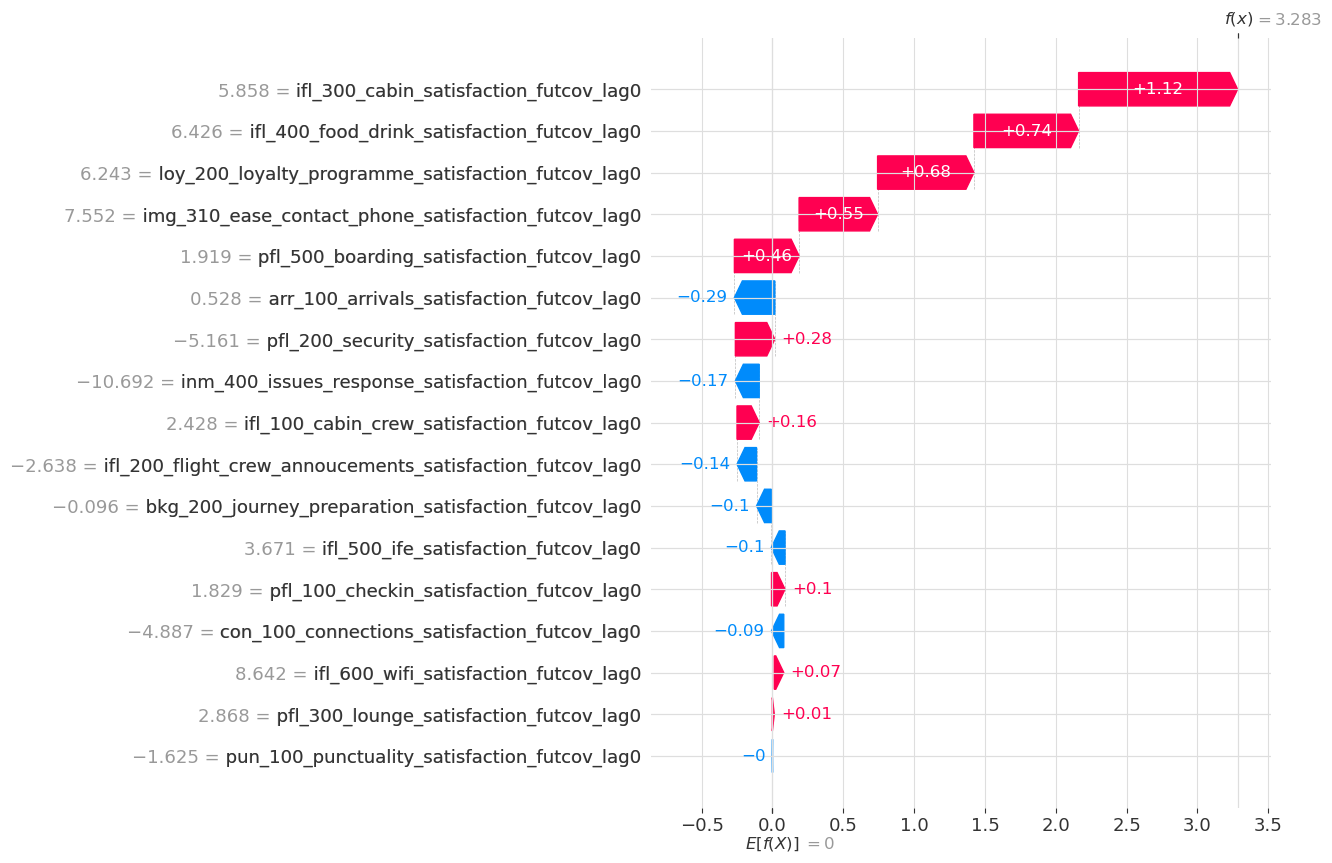

In [55]:
dif_exp=create_difference_explanation(explanation[months_dict['2022/01']],explanation[months_dict['2023/01']])
shap.plots.waterfall(shap_values=dif_exp, max_display=30)

### Economy SH

In [56]:
key='Economy_SH_df'
ts=pred_ts_dict_mae[key]
back_ts=nps_ts_dict_mae[key]
exp_df=monthly_grouped_dfs[key]
exp_df['date_flight_local'] = pd.to_datetime(exp_df['date_flight_local'])
exp_df = exp_df.set_index('date_flight_local')

#past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
future_covariates_ts = TimeSeries.from_series(exp_df[features[key]], freq='M')
                
future_scaler = future_scaler_dict_mae[key]
future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

# Load the pre-trained model
model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{key}_RandomForest.pkl")
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)
    
shap_explain = ShapExplainer(model=model)
shap_explained = shap_explain.explain(ts,foreground_future_covariates=future_covariates_ts_scaled)
explanation=shap_explained.get_shap_explanation_object(horizon=1)

if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    past_lags=best_mae_models_by_dataframe[key]['params']['lags_past_covariates']
future_lags=best_mae_models_by_dataframe[key]['params']['lags_future_covariates']

# Apply the transformation for each lag in past_lags
if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    for lag in past_lags:
        # Select columns for the current lag of past covariates
        current_past_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"pastcov_lag{lag}" in feature]
        # Select data for the current lag of past covariates
        data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]
    
        # Apply the transformation and store the result
        transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
        explanation.data[:, current_past_covariates_indices] = transformed_past_data

# Apply the transformation for each lag in future_lags
for lag in future_lags:
    # Select columns for the current lag of future covariates
    current_future_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"futcov_lag{lag}" in feature]
    
    # Select data for the current lag of future covariates
    data_for_current_future_covariates = explanation.data[:, current_future_covariates_indices]
    
    # Apply the transformation and store the result
    transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()
    
    explanation.data[:, current_future_covariates_indices] = transformed_future_data

Permutation explainer: 33it [00:17,  1.27s/it]                        


In [57]:
shap_explain.force_plot_from_ts(ts,foreground_future_covariates=future_covariates_ts_scaled)

Permutation explainer: 33it [00:18,  1.24s/it]                        


Top correlated features for 'Economy_SH_df': pun_100_punctuality_satisfaction, pfl_500_boarding_satisfaction, ifl_100_cabin_crew_satisfaction, arr_100_arrivals_satisfaction, pfl_100_checkin_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, ifl_300_cabin_satisfaction, pfl_200_security_satisfaction, bkg_200_journey_preparation_satisfaction, ifl_400_food_drink_satisfaction, img_310_ease_contact_phone_satisfaction, con_100_connections_satisfaction, loy_200_loyalty_programme_satisfaction, inm_400_issues_response_satisfaction, ifl_600_wifi_satisfaction, pfl_300_lounge_satisfaction, ifl_500_ife_satisfaction


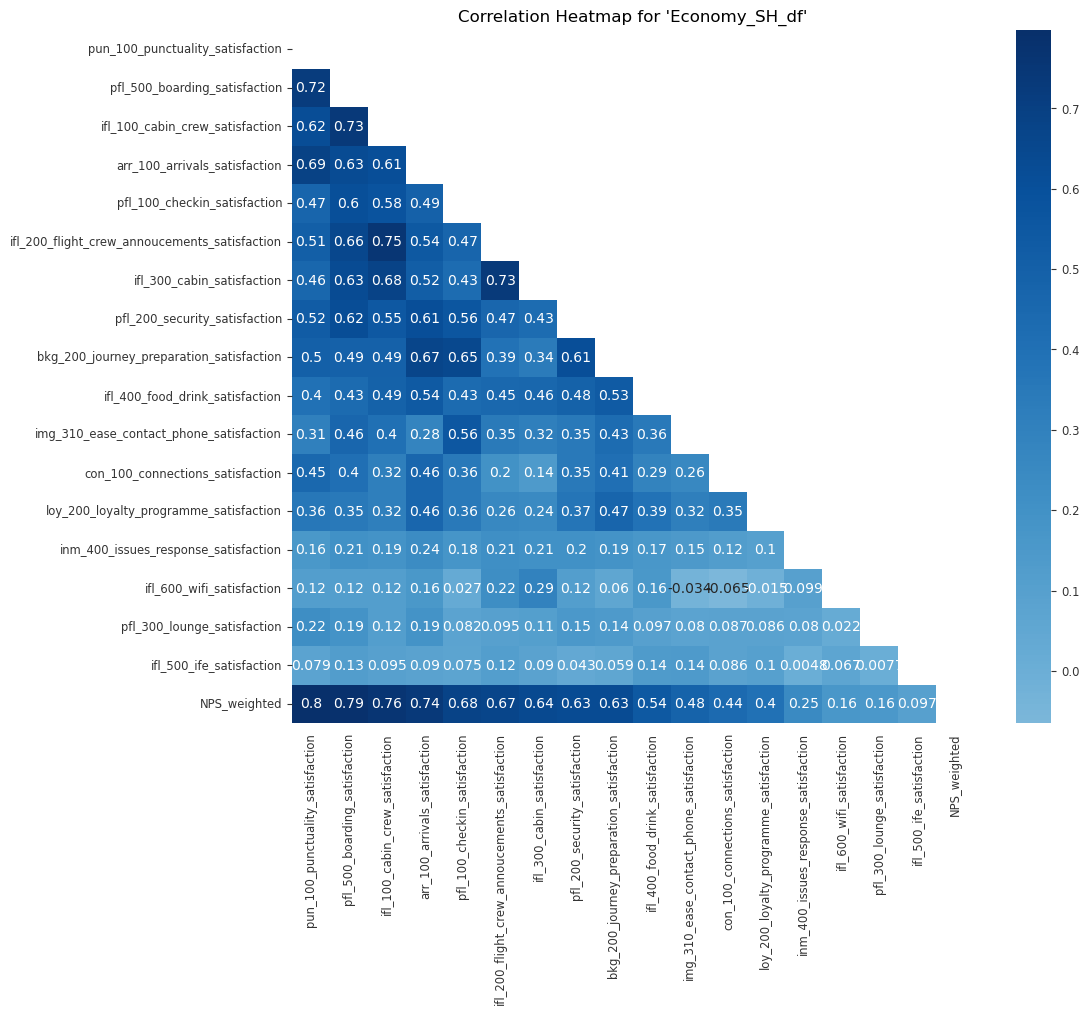

In [58]:
# Get the top correlated features and the correlation matrix for this DataFrame
top_correlated_features, correlation_matrix = get_top_correlated_features(grouped_dfs[key], 17)
    
# Print the top correlated features
print(f"Top correlated features for '{key}': {', '.join(top_correlated_features)}")
    
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, mask=mask)
plt.title(f"Correlation Heatmap for '{key}'")
plt.show()

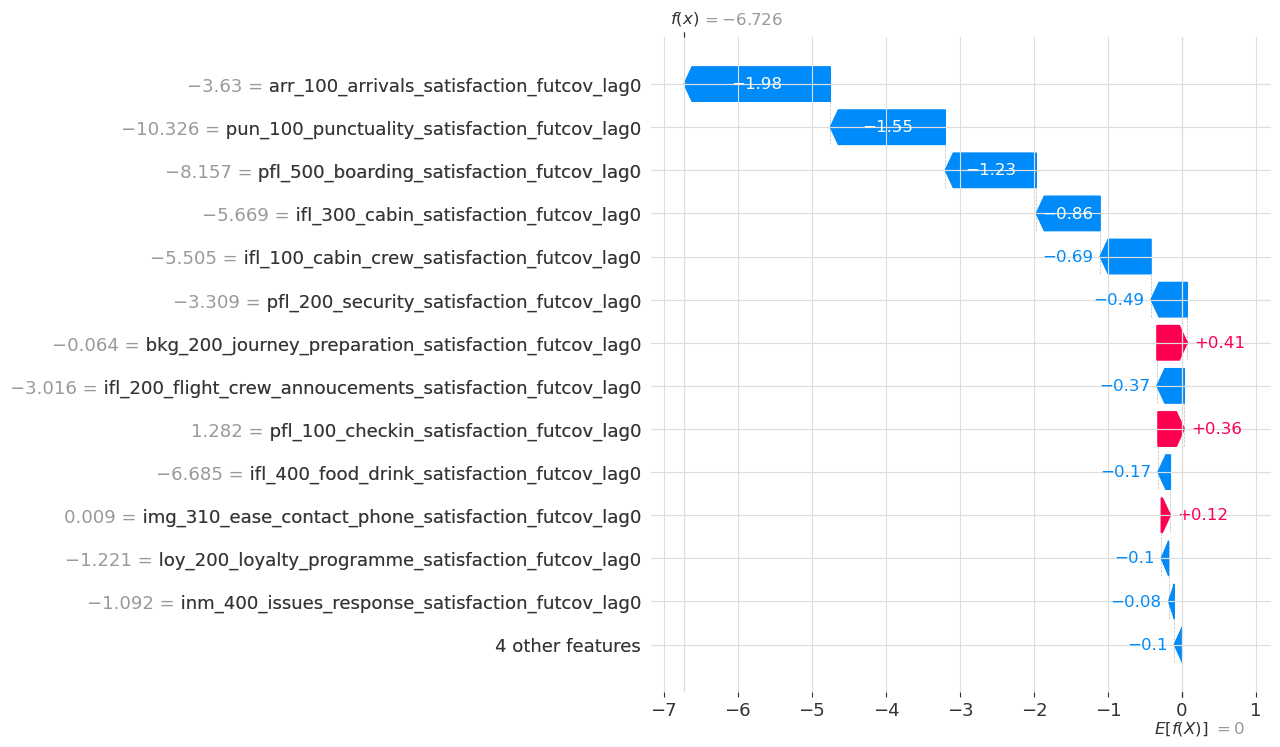

In [59]:
dif_exp=create_difference_explanation(explanation[months_dict['2022/01']],explanation[months_dict['2023/01']])
shap.plots.waterfall(shap_values=dif_exp, max_display=14)

### Economy LH

In [60]:
key='Economy_LH_df'
ts=pred_ts_dict_mae[key]
back_ts=nps_ts_dict_mae[key]
exp_df=monthly_grouped_dfs[key]
exp_df['date_flight_local'] = pd.to_datetime(exp_df['date_flight_local'])
exp_df = exp_df.set_index('date_flight_local')

#past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
future_covariates_ts = TimeSeries.from_series(exp_df[features[key]], freq='M')
                
future_scaler = future_scaler_dict_mae[key]
future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

# Load the pre-trained model
model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{key}_RandomForest.pkl")
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)
    
shap_explain = ShapExplainer(model=model)
shap_explained = shap_explain.explain(ts,foreground_future_covariates=future_covariates_ts_scaled)
explanation=shap_explained.get_shap_explanation_object(horizon=1)

if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    past_lags=best_mae_models_by_dataframe[key]['params']['lags_past_covariates']
future_lags=best_mae_models_by_dataframe[key]['params']['lags_future_covariates']

# Apply the transformation for each lag in past_lags
if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    for lag in past_lags:
        # Select columns for the current lag of past covariates
        current_past_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"pastcov_lag{lag}" in feature]
        # Select data for the current lag of past covariates
        data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]
    
        # Apply the transformation and store the result
        transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
        explanation.data[:, current_past_covariates_indices] = transformed_past_data

# Apply the transformation for each lag in future_lags
for lag in future_lags:
    # Select columns for the current lag of future covariates
    current_future_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"futcov_lag{lag}" in feature]
    
    # Select data for the current lag of future covariates
    data_for_current_future_covariates = explanation.data[:, current_future_covariates_indices]
    
    # Apply the transformation and store the result
    transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()
    
    explanation.data[:, current_future_covariates_indices] = transformed_future_data

Permutation explainer: 33it [00:17,  1.25s/it]                        


In [61]:
shap_explain.force_plot_from_ts(ts,foreground_future_covariates=future_covariates_ts_scaled)

Permutation explainer: 33it [00:18,  1.30s/it]                        


Top correlated features for 'Economy_LH_df': ifl_100_cabin_crew_satisfaction, pfl_100_checkin_satisfaction, ifl_300_cabin_satisfaction, bkg_200_journey_preparation_satisfaction, arr_100_arrivals_satisfaction, ifl_400_food_drink_satisfaction, pfl_500_boarding_satisfaction, pun_100_punctuality_satisfaction, pfl_200_security_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, img_310_ease_contact_phone_satisfaction, loy_200_loyalty_programme_satisfaction, con_100_connections_satisfaction, ifl_500_ife_satisfaction, inm_400_issues_response_satisfaction, pfl_300_lounge_satisfaction, ifl_600_wifi_satisfaction


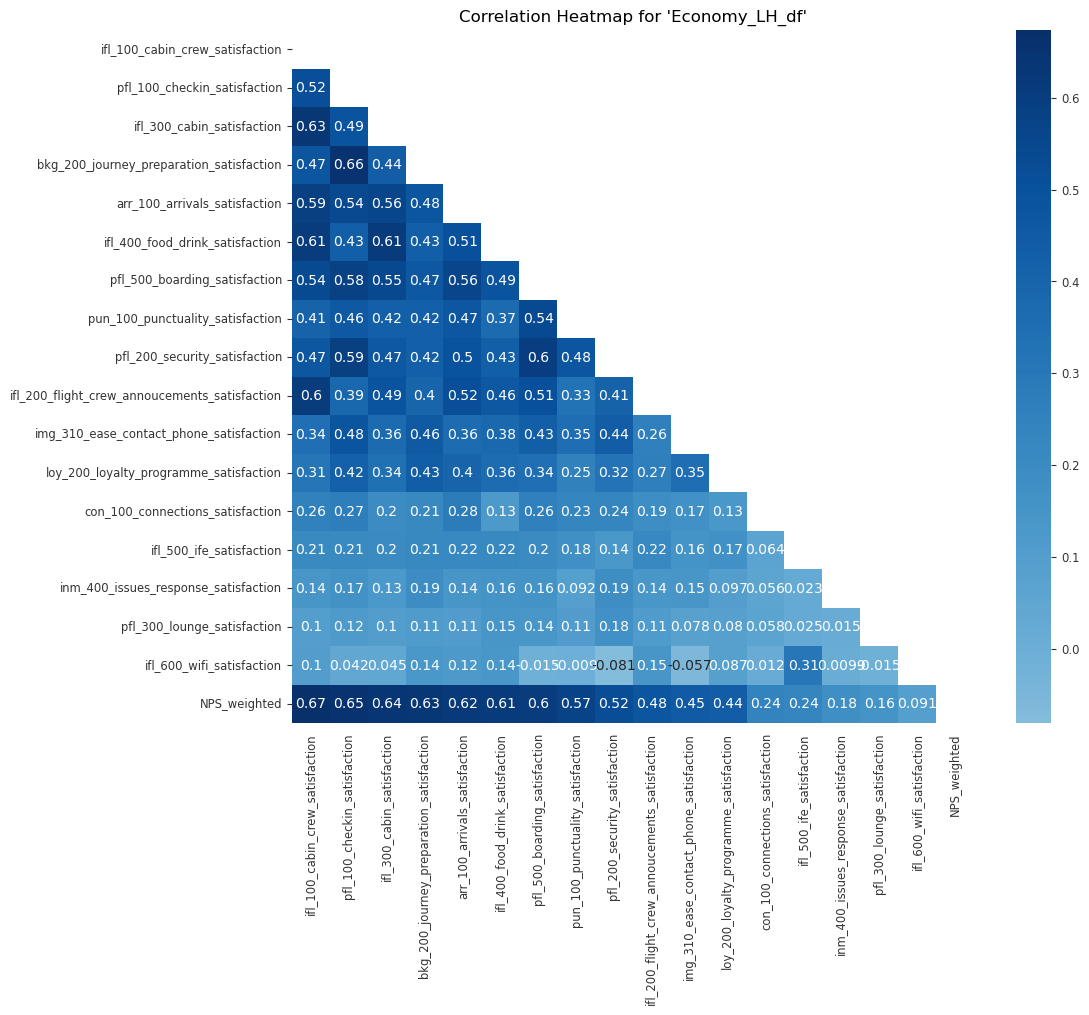

In [62]:
# Get the top correlated features and the correlation matrix for this DataFrame
top_correlated_features, correlation_matrix = get_top_correlated_features(grouped_dfs[key], 17)
    
# Print the top correlated features
print(f"Top correlated features for '{key}': {', '.join(top_correlated_features)}")
    
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, mask=mask)
plt.title(f"Correlation Heatmap for '{key}'")
plt.show()

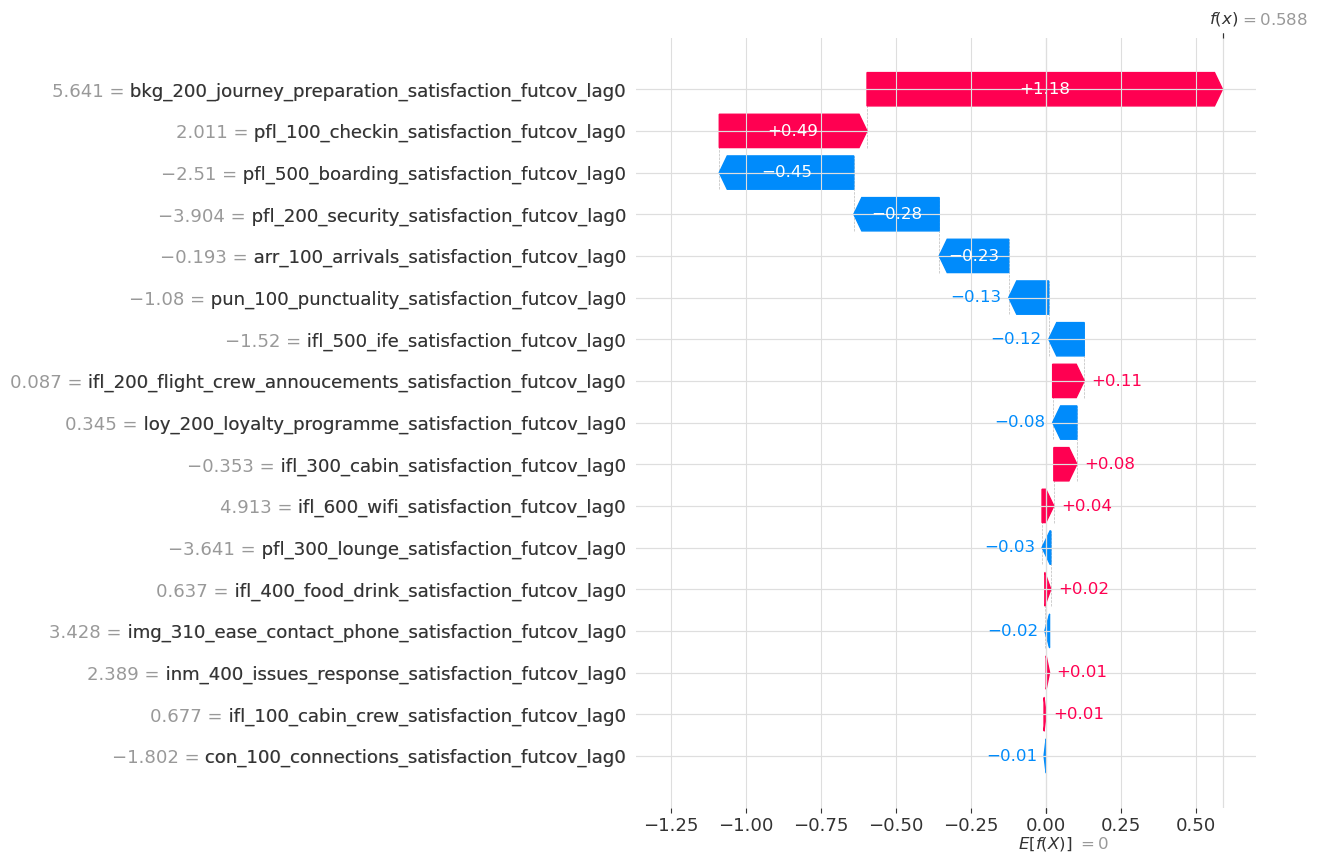

In [63]:
dif_exp=create_difference_explanation(explanation[months_dict['2022/01']],explanation[months_dict['2023/01']])
shap.plots.waterfall(shap_values=dif_exp, max_display=30)

### Premium Economy

In [64]:
key='Premium Economy_LH_df'
ts=pred_ts_dict_mae[key]
back_ts=nps_ts_dict_mae[key]
exp_df=monthly_grouped_dfs[key]
exp_df['date_flight_local'] = pd.to_datetime(exp_df['date_flight_local'])
exp_df = exp_df.set_index('date_flight_local')

#past_covariates_ts = TimeSeries.from_series(exp_df[lag_features[key]], freq='M')
future_covariates_ts = TimeSeries.from_series(exp_df[features[key]], freq='M')
                
future_scaler = future_scaler_dict_mae[key]
future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

# Load the pre-trained model
model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{key}_RandomForest.pkl")
with open(model_file_path, 'rb') as model_file:
    model = pickle.load(model_file)
    
shap_explain = ShapExplainer(model=model)
shap_explained = shap_explain.explain(ts, foreground_future_covariates=future_covariates_ts_scaled)
explanation=shap_explained.get_shap_explanation_object(horizon=1)

if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    past_lags=best_mae_models_by_dataframe[key]['params']['lags_past_covariates']
future_lags=best_mae_models_by_dataframe[key]['params']['lags_future_covariates']

# Apply the transformation for each lag in past_lags
if 'lags_past_covariates' in best_mae_models_by_dataframe[key]['params'].keys():
    for lag in past_lags:
        # Select columns for the current lag of past covariates
        current_past_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"pastcov_lag{lag}" in feature]
        # Select data for the current lag of past covariates
        data_for_current_past_covariates = explanation.data[:, current_past_covariates_indices]
    
        # Apply the transformation and store the result
        transformed_past_data = past_scaler.inverse_transform(TimeSeries.from_series(data_for_current_past_covariates)).values()
        explanation.data[:, current_past_covariates_indices] = transformed_past_data

# Apply the transformation for each lag in future_lags
for lag in future_lags:
    # Select columns for the current lag of future covariates
    current_future_covariates_indices = [i for i, feature in enumerate(explanation.feature_names) if f"futcov_lag{lag}" in feature]
    
    # Select data for the current lag of future covariates
    data_for_current_future_covariates = explanation.data[:, current_future_covariates_indices]
    
    # Apply the transformation and store the result
    transformed_future_data = future_scaler.inverse_transform(TimeSeries.from_series(data_for_current_future_covariates)).values()
    
    explanation.data[:, current_future_covariates_indices] = transformed_future_data

Permutation explainer: 33it [00:18,  1.23s/it]                        


In [65]:
shap_explain.force_plot_from_ts(ts,foreground_future_covariates=future_covariates_ts_scaled)
# shap_explain.force_plot_from_ts(ts,foreground_past_covariates=past_covariates_ts_scaled,foreground_future_covariates=future_covariates_ts_scaled)

Permutation explainer: 33it [00:18,  1.22s/it]                        


Top correlated features for 'Premium Economy_LH_df': ifl_100_cabin_crew_satisfaction, ifl_300_cabin_satisfaction, ifl_400_food_drink_satisfaction, pfl_100_checkin_satisfaction, pfl_500_boarding_satisfaction, ifl_200_flight_crew_annoucements_satisfaction, pun_100_punctuality_satisfaction, arr_100_arrivals_satisfaction, bkg_200_journey_preparation_satisfaction, loy_200_loyalty_programme_satisfaction, pfl_200_security_satisfaction, ifl_500_ife_satisfaction, img_310_ease_contact_phone_satisfaction, con_100_connections_satisfaction, ifl_600_wifi_satisfaction, pfl_300_lounge_satisfaction, inm_400_issues_response_satisfaction


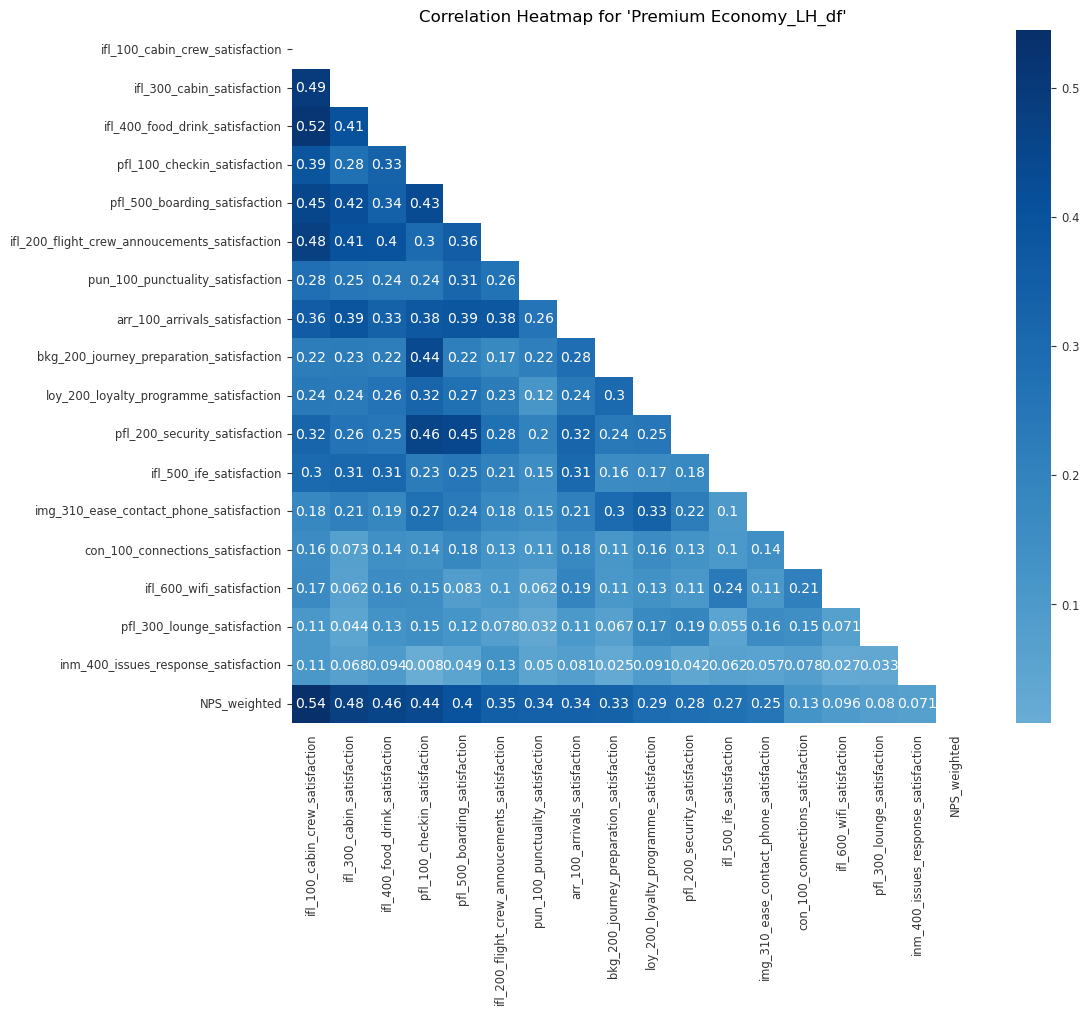

In [66]:
# Get the top correlated features and the correlation matrix for this DataFrame
top_correlated_features, correlation_matrix = get_top_correlated_features(grouped_dfs[key], 17)
    
# Print the top correlated features
print(f"Top correlated features for '{key}': {', '.join(top_correlated_features)}")
    
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
# Plot the heatmap
plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", center=0, mask=mask)
plt.title(f"Correlation Heatmap for '{df_id}'")
plt.show()

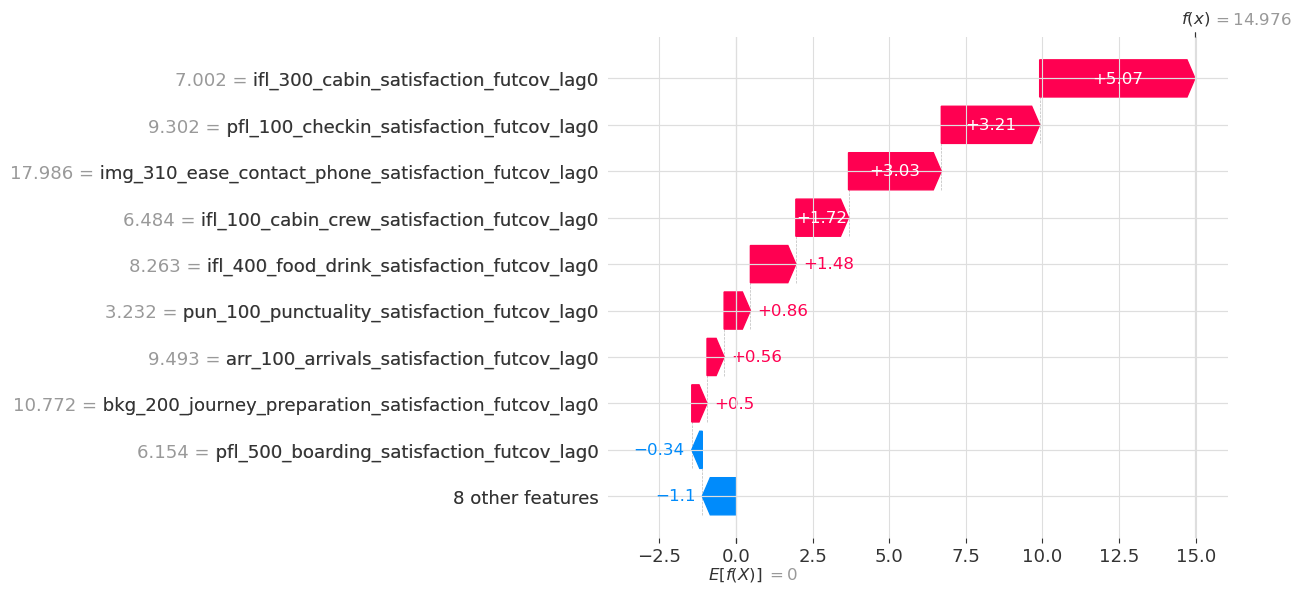

In [67]:
dif_exp=create_difference_explanation(explanation[months_dict['2022/01']],explanation[months_dict['2023/01']])
shap.plots.waterfall(shap_values=dif_exp, max_display=10)

# Backlock

In [ ]:

shaps={}

def run_shapley_values_mae(models_by_dataframe, nps_ts_dict, output_dir):
    for df_id, value in models_by_dataframe.items():
        model_name = value['model_name']
        model_params = value['params']
        pred_series = value['pred_series']

        df=grouped_dfs[df_id]
        df['date'] = pd.to_datetime(df['date_flight_local'])
        df = df.set_index('date')
        df = df.fillna(0)
        
        train_ts,val_ts = nps_ts_dict[df_id][:-12],nps_ts_dict[df_id][-12:]

        past_covariates_ts = TimeSeries.from_series(df[lag_features[df_id]], freq='M')
        future_covariates_ts = TimeSeries.from_series(df[features[df_id]], freq='M')
                
        train_past_covariates_ts,val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
        train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6]  , future_covariates_ts[-6:]
        
        nps_scaler = Scaler()
        nps_scaler.fit(train_ts)
        nps_ts_dict_scaled = nps_scaler.transform(nps_ts_dict[key])
        train_ts_scaled=nps_scaler.transform(train_ts)
        val_ts_scaled= nps_scaler.transform(val_ts)
        pred_series_scaled=nps_scaler.transform(pred_series)
                
        past_scaler = Scaler()
        past_scaler.fit(train_past_covariates_ts)
        past_covariates_ts_scaled=past_scaler.transform(past_covariates_ts)
        train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts)
        val_past_covariates_ts_scaled=past_scaler.transform(val_past_covariates_ts)        
                
        future_scaler = Scaler()
        future_scaler.fit(train_future_covariates_ts)
        future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
        train_future_covariates_ts_scaled=future_scaler.transform(train_future_covariates_ts)
        val_future_covariates_ts_scaled=future_scaler.transform(val_future_covariates_ts)
    
        # Load the pre-trained model
        model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{df_id}_{model_name}.pkl")
        with open(model_file_path, 'rb') as model_file:
            model = pickle.load(model_file)
            
        if "lags_past_covariates" in model_params:
            # Compute Shapley values
            shap_explain = ShapExplainer(model=model, background_series = train_ts_scaled, background_future_covariates = train_future_covariates_ts_scaled, background_past_covariates = train_past_covariates_ts_scaled)
            shaps[key] = shap_explain.explain(foreground_series=pred_series_scaled,foreground_future_covariates=val_future_covariates_ts_scaled, foreground_past_covariates= val_past_covariates_ts_scaled)
        else:
            # Compute Shapley values
            shap_explain = ShapExplainer(model=model, background_series = train_ts_scaled, background_future_covariates = train_future_covariates_ts_scaled)
            shaps[key] = shap_explain.explain(foreground_series=pred_series_scaled,foreground_future_covariates=val_future_covariates_ts_scaled)
            
        print(shaps[key])
        

# Run the Shapley value computation and create plots
run_shapley_values_mae(best_mae_models_by_dataframe, nps_ts_dict_mae, output_dir)


In [ ]:

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
shaps={}
output={}
feature_values={}
shap_objects={}

def run_shapley_values_mae(models_by_dataframe, nps_ts_dict, output_dir):
    for df_id, value in models_by_dataframe.items():
        model_name = value['model_name']
        model_params = value['params']
        pred_series = value['pred_series']

        df=grouped_dfs[df_id]
        df['date'] = pd.to_datetime(df['date_flight_local'])
        df = df.set_index('date')
        df = df.fillna(0)
        
        train_ts,val_ts = nps_ts_dict[df_id][:-12],nps_ts_dict[df_id][-12:]

        past_covariates_ts = TimeSeries.from_series(df[lag_features[df_id]], freq='M')
        future_covariates_ts = TimeSeries.from_series(df[features[df_id]], freq='M')
                
        train_past_covariates_ts,val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
        train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6]  , future_covariates_ts[-6:]
        
        nps_scaler = Scaler()
        nps_scaler.fit(train_ts)
        nps_ts_dict_scaled = nps_scaler.transform(nps_ts_dict[key])
        train_ts_scaled=nps_scaler.transform(train_ts)
        val_ts_scaled= nps_scaler.transform(val_ts)
        pred_series_scaled=nps_scaler.transform(pred_series)
                
        past_scaler = Scaler()
        past_scaler.fit(train_past_covariates_ts)
        past_covariates_ts_scaled=past_scaler.transform(past_covariates_ts)
        train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts)
        val_past_covariates_ts_scaled=past_scaler.transform(val_past_covariates_ts)        
                
        future_scaler = Scaler()
        future_scaler.fit(train_future_covariates_ts)
        future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
        train_future_covariates_ts_scaled=future_scaler.transform(train_future_covariates_ts)
        val_future_covariates_ts_scaled=future_scaler.transform(val_future_covariates_ts)
    
        # Load the pre-trained model
        model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mae_model_{df_id}_{model_name}.pkl")
        with open(model_file_path, 'rb') as model_file:
            model = pickle.load(model_file)
            
        if "lags_past_covariates" in model_params:
            # Compute Shapley values
            shap_explain = ShapExplainer(model=model, background_series = train_ts_scaled, background_future_covariates = train_future_covariates_ts_scaled, background_past_covariates = train_past_covariates_ts_scaled)
            shaps[df_id] = shap_explain.explain(foreground_series=pred_series_scaled,foreground_future_covariates=val_future_covariates_ts_scaled, foreground_past_covariates= val_past_covariates_ts_scaled)
        else:
            # Compute Shapley values
            shap_explain = ShapExplainer(model=model, background_series = train_ts_scaled, background_future_covariates = train_future_covariates_ts_scaled)
            shaps[df_id] = shap_explain.explain(foreground_series=pred_series_scaled,foreground_future_covariates=val_future_covariates_ts_scaled)
            
        print(shaps[df_id])        
        output[df_id] = shaps[df_id].get_explanation(horizon=1, component="NPS_weighted")
        feature_values[df_id] = shaps[df_id].get_feature_values(horizon=1, component="NPS_weighted")
        shap_objects[df_id] = shaps[df_id].get_shap_explanation_object(horizon=1, component="NPS_weighted")
        

# Run the Shapley value computation and create plots
run_shapley_values_mae(best_mae_models_by_dataframe, nps_ts_dict_mae, output_dir)

In [ ]:
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
def train_and_save_best_mae_models(models, model_params_list, grouped_dfs, output_dir, model_save_dir):
    best_models_by_dataframe = {}

    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    
    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df = grouped_dfs[key]
                df['date'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date')
                df = df.fillna(0)
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='M')                  
                train_ts, val_ts = nps_ts_dict[key][:-6], nps_ts_dict[key][-6:]

                past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
                future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')
                
                train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]  
                
                nps_scaler = Scaler()
                nps_scaler.fit(train_ts)
                train_ts_scaled = nps_scaler.transform(train_ts)
                
                past_scaler = Scaler()
                past_scaler.fit(train_past_covariates_ts)
                past_covariates_ts_scaled = past_scaler.transform(past_covariates_ts)                
                train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts)
                
                future_scaler = Scaler()
                future_scaler.fit(train_future_covariates_ts)
                future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
                train_future_covariates_ts_scaled = future_scaler.transform(train_future_covariates_ts)

                if model_name == 'LightGBMModel':
                    model = LightGBMModel(**model_params)
                elif model_name == 'RandomForest':
                    model = RandomForest(**model_params)
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")
                
                if "lags_past_covariates" in model_params.keys():
                    model.fit(train_ts_scaled, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)
                    pred_series_scaled = model.predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                else:
                    model.fit(train_ts_scaled, future_covariates=train_future_covariates_ts_scaled)
                    pred_series_scaled = model.predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled)
                    
                pred_series = nps_scaler.inverse_transform(pred_series_scaled)
                mae = mean_absolute_error(val_ts.values(), pred_series.values())
                mape = mean_absolute_percentage_error(val_ts.values(), pred_series.values())

                if key not in best_models_by_dataframe or mae < best_models_by_dataframe[key]['mae']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'params': model_params,
                        'pred_series': pred_series,
                        'model': model  # Save the model instance in the dictionary
                    }

    # Save the best models after all loops
    for df_id, value in best_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir, f"best_mae_model_{df_id}_{value['model_name']}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        nps_ts_dict[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mae - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_{df_id}_mae_{value['model_name']}.png")
        plt.close()

    return best_models_by_dataframe, nps_ts_dict

# Assuming you have the grouped_dfs dictionary defined
best_mae_models_by_dataframe, nps_ts_dict_mae = train_and_save_best_mae_models(models, model_params, grouped_dfs, output_dir, models_dir)
import pickle
def train_and_save_best_mape_models(models, model_params_list, grouped_dfs, output_dir, model_save_dir):
    best_models_by_dataframe = {}

    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    
    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df = grouped_dfs[key]
                df['date'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date')
                df = df.fillna(0)
                
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='M')                  
                train_ts, val_ts = nps_ts_dict[key][:-6], nps_ts_dict[key][-6:]

                past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
                future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')
                
                train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]  
                
                nps_scaler = Scaler()
                nps_scaler.fit(train_ts)
                train_ts_scaled = nps_scaler.transform(train_ts)
                
                past_scaler = Scaler()
                past_scaler.fit(train_past_covariates_ts)
                past_covariates_ts_scaled = past_scaler.transform(past_covariates_ts)                
                train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts)
                
                future_scaler = Scaler()
                future_scaler.fit(train_future_covariates_ts)
                future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
                train_future_covariates_ts_scaled = future_scaler.transform(train_future_covariates_ts)

                if model_name == 'LightGBMModel':
                    model = LightGBMModel(**model_params)
                elif model_name == 'RandomForest':
                    model = RandomForest(**model_params)
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                if "lags_past_covariates" in model_params.keys():
                    model.fit(train_ts_scaled, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)
                    pred_series_scaled = model.predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                else:
                    model.fit(train_ts_scaled, future_covariates=train_future_covariates_ts)
                    pred_series_scaled = model.predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled)
                
                pred_series = nps_scaler.inverse_transform(pred_series_scaled)
                mae = mean_absolute_error(val_ts.values(), pred_series.values())
                mape = mean_absolute_percentage_error(val_ts.values(), pred_series.values())

                if key not in best_models_by_dataframe or mape < best_models_by_dataframe[key]['mape']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'params': model_params,
                        'pred_series': pred_series,
                        'model': model  # Save the model instance in the dictionary
                    }

    # Save the best models after all loops
    for df_id, value in best_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir, f"best_mape_model_{df_id}_{value['model_name']}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        nps_ts_dict[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mape - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS ajusted")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_{df_id}_mape_{value['model_name']}.png")
        plt.close()

    return best_models_by_dataframe, nps_ts_dict

# Assuming you have the grouped_dfs dictionary defined
best_mape_models_by_dataframe, nps_ts_dict_mape = train_and_save_best_mape_models(models, model_params, grouped_dfs, output_dir, models_dir)

def run_backtest_mape(models_by_dataframe, nps_ts_dict, output_dir):
    for df_id, value in models_by_dataframe.items():
        model_name = value['model_name']
        model_params = value['params']
        pred_series = value['pred_series']

        df=grouped_dfs[df_id]
        df['date'] = pd.to_datetime(df['date_flight_local'])
        df = df.set_index('date')
        df = df.fillna(0)
        
        train_ts = nps_ts_dict[df_id][:-6]

        past_covariates_ts = TimeSeries.from_series(df[lag_features[df_id]], freq='M')
        future_covariates_ts = TimeSeries.from_series(df[features[df_id]], freq='M')
                
        train_past_covariates_ts = past_covariates_ts[:-6]
        train_future_covariates_ts = future_covariates_ts[:-6]  
        
        nps_scaler = Scaler()
        nps_scaler.fit(train_ts)
        nps_ts_dict_scaled = nps_scaler.transform(train_ts)
                
        past_scaler = Scaler()
        past_scaler.fit(train_past_covariates_ts)
        past_covariates_ts_scaled = past_scaler.transform(past_covariates_ts)                
                
        future_scaler = Scaler()
        future_scaler.fit(train_future_covariates_ts)
        future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)

        # Load the pre-trained model
        model_file_path = os.path.join('best_models_Adjusted_NPS', f"best_mape_model_{df_id}_{model_name}.pkl")
        with open(model_file_path, 'rb') as model_file:
            model = pickle.load(model_file)

        
        if "lags_past_covariates" in model_params:
            # Run the backtest
            backtest_scaled = model.historical_forecasts(
                nps_ts_dict_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled, start=None, forecast_horizon=6, verbose=True, retrain = False 
            )
        else:
            # Run the backtest
            backtest_scaled = model.historical_forecasts(
                nps_ts_dict_scaled, future_covariates=future_covariates_ts_scaled, start=None, forecast_horizon=6, verbose=True, retrain = False
            )
        
        backtest=nps_scaler.inverse_transform(backtest_scaled)
        print(f"Backtest MAE for '{df_id}' using {model_name}: %.2f" % (mae(backtest, nps_ts_dict[df_id])))
        print(f"Backtest MAPE for '{df_id}' using {model_name}: %.2f" % (mape(backtest, nps_ts_dict[df_id])))
        
        # Plot the results
        plt.figure(figsize=(10, 6))
        pred_series.plot(label='Predicted NPS')
        nps_ts_dict[df_id].plot(label='Actual NPS')
        backtest.plot(label='Backtest NPS Forecast')
        plt.title(f"'{df_id}' - {model_name} - Backtest")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir}/mape_backtest_{df_id}_{model_name}.png")
        plt.close()

        
        # Run the backtest for best MAPE models
run_backtest_mape(best_mape_models_by_dataframe, nps_ts_dict_mape, output_dir)

## Tuning

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, PassiveAggressiveRegressor, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import TheilSenRegressor, PoissonRegressor, GammaRegressor

regression_models = [
    LinearRegression(), Lasso(), ElasticNet(), HuberRegressor(), PassiveAggressiveRegressor(), SGDRegressor(),
    Ridge(),
    DecisionTreeRegressor(),
    RandomForestRegressor(), GradientBoostingRegressor(), BaggingRegressor(), AdaBoostRegressor(),
    SVR(),
    KNeighborsRegressor(),
    GaussianProcessRegressor(),
    TheilSenRegressor(), PoissonRegressor()
]


import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import RegressionModel
def train_and_save_best_mae_models(models, model_params_list, grouped_dfs, output_dir, model_save_dir):
    best_models_by_dataframe = {}
    model={}

    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    
    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df = grouped_dfs[key]
                df['date'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date')
                df = df.fillna(0)
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='M')                  
                train_ts, val_ts = nps_ts_dict[key][:-6], nps_ts_dict[key][-6:]

                past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
                future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')
                
                train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]  
                
                model[key]=RegressionModel(model=model_name, **model_params)
                
                nps_scaler = Scaler()
                nps_scaler.fit(train_ts)
                train_ts_scaled = nps_scaler.transform(train_ts)
                
                past_scaler = Scaler()
                past_scaler.fit(train_past_covariates_ts)
                past_covariates_ts_scaled = past_scaler.transform(past_covariates_ts)                
                train_past_covariates_ts_scaled = past_scaler.transform(train_past_covariates_ts)
                
                future_scaler = Scaler()
                future_scaler.fit(train_future_covariates_ts)
                future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
                train_future_covariates_ts_scaled = future_scaler.transform(train_future_covariates_ts)
                
                if "lags_past_covariates" in model_params.keys():
                    model[key].fit(train_ts_scaled, future_covariates=train_future_covariates_ts_scaled, past_covariates=train_past_covariates_ts_scaled)
                    pred_series_scaled = model[key].predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
                else:
                    model[key].fit(train_ts_scaled, future_covariates=train_future_covariates_ts_scaled)
                    pred_series_scaled = model[key].predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled)
                    
                pred_series = nps_scaler.inverse_transform(pred_series_scaled)
                mae = mean_absolute_error(val_ts.values(), pred_series.values())
                mape = mean_absolute_percentage_error(val_ts.values(), pred_series.values())

                if key not in best_models_by_dataframe or mae < best_models_by_dataframe[key]['mae']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'params': model_params,
                        'pred_series': pred_series,
                        'model': model[key]  # Save the model instance in the dictionary
                    }

    # Save the best models after all loops
    for df_id, value in best_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir, f"best_mae_model_{df_id}_{value['model_name']}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        nps_ts_dict[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mae - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_{df_id}_mae_{value['model_name']}.png")
        plt.close()

    return best_models_by_dataframe, nps_ts_dict

# Assuming you have the grouped_dfs dictionary defined
best_mae_models_by_dataframe, nps_ts_dict_mae = train_and_save_best_mae_models(regression_models, model_params, grouped_dfs, output_dir, models_dir)

In [ ]:
output_dir = "tuning_Adjusted_NPS"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
models = ['LinearRegressionModel']
add_encoders = {
    'cyclic': {'future': ['month']},
    'transformer': Scaler()
}
model_params = [
    

    # Temporal lags for NPS and covariates
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6], "output_chunk_length": 1},
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1, -3, -6], "output_chunk_length": 1},
    
    # Temporal lags for the NPS alone.
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 12, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},      
    
    # Temporal lags for the covariates alone.
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1,-2,-3,-4,-5,-6], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -3, -6], "output_chunk_length": 1},
    
    # Almost Non temporal lags. 
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1], "output_chunk_length": 1},
    {"lags": 1, "lags_future_covariates": [0,1], "lags_past_covariates": [-1], "output_chunk_length": 2},
    {"lags": 1, "lags_future_covariates": [0,1,2], "lags_past_covariates": [-1], "output_chunk_length": 3},
    
    # Non temporal lags. 
    {"lags_future_covariates": [0], "output_chunk_length": 1},
    {"lags_future_covariates": [0,1], "output_chunk_length": 2},
    {"lags_future_covariates": [0,1,2], "output_chunk_length": 3},
    {"lags_future_covariates": [0,1,2,3,4,5], "output_chunk_length": 6},
    
]

output_dir = "tuning_Adjusted_NPS"

In [ ]:
#Linear regression hyperparameters
params_grid ={
    
    "LightGBMModel": {        
        "lags":[1, 6, 12],
        "lags_future_covariates": [1], 
        "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], 
        "output_chunk_length": [1],
        'boosting_type': ['gbdt', 'dart', 'goss'],  # Type of boosting algorithm
        'num_leaves': [20, 30, 50],                # Maximum number of leaves in one tree
        'learning_rate': [0.01, 0.1, 0.2],         # Step size at each iteration
        'n_estimators': [50, 100, 200],            # Number of boosting iterations
        'subsample': [0.8, 1.0],                   # Subsample ratio of the training instances
        'colsample_bytree': [0.8, 1.0],            # Subsample ratio of columns when constructing each tree
        'reg_alpha': [0.0, 0.1, 0.5],              # L1 regularization term on weights
        'reg_lambda': [0.0, 0.1, 0.5],             # L2 regularization term on weights
    },
    "RandomForest": {        
        "lags":[1, 6, 12],
        "lags_future_covariates": [1], 
        "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], 
        "output_chunk_length": [1],
        'n_estimators': [50, 100, 200],            # Number of trees in the forest
        'max_depth': [10, 20],                # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt'],           # Number of features to consider when looking for the best split
        'bootstrap': [True, False],                 # Whether bootstrap samples are used when building trees
    },
    "LinearRegressionModel": {
        "lags":[1, 6, 12],
        "lags_future_covariates": [1], 
        "lags_past_covariates": [-1, -2, -3, -4, -5, -6,-7,-8,-9,-10,-11,-12], 
        "output_chunk_length": [2],
        'fit_intercept': [True, False],  # Whether to calculate the intercept for the model
    }
}


In [ ]:
def grid_fine_tune(train_ts_scaled, model_name, params_dict, past_covariates_ts_scaled, future_covariates_ts_scaled):
    if model_name == 'LightGBMModel':
        # Run the gridsearch
        best_model = LightGBMModel.gridsearch(
            parameters = params_dict, series = train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled, start=0.4, stride=1, forecast_horizon=6, verbose=True
        )
    elif model_name == 'RandomForest':
        # Run the gridsearch
        best_model = RandomForest.gridsearch(
            parameters = params_dict, series = train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled, start=0.4, stride=1, forecast_horizon=6, verbose=True
        )
    elif model_name == 'LinearRegressionModel':
        # Run the gridsearch
        best_model = LinearRegressionModel.gridsearch(
            parameters = params_dict, series = train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled, start=0.4, stride=1, forecast_horizon=6, verbose=True
        )
    else:
        raise ValueError(f"Unknown model name: {model_name}")  
        
    return best_model
    
    

In [ ]:
best_model={}
nps_ts_dict={}
for key in grouped_dfs.keys():
    df = grouped_dfs[key]
    df['date'] = pd.to_datetime(df['date_flight_local'])
    nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='M')                  
    train_ts, val_ts = nps_ts_dict[key][:-6], nps_ts_dict[key][-6:]

    past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')
                
    scaler = Scaler()
    nps_ts_dict_scaled, past_covariates_ts_scaled, future_covariates_ts_scaled = scaler.fit_transform([nps_ts_dict[key], past_covariates_ts, future_covariates_ts])

    train_ts_scaled, val_ts_scaled = nps_ts_dict_scaled[:-6], nps_ts_dict_scaled[-6:]
    train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts_scaled[:-6], past_covariates_ts_scaled[-6:]
    train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts_scaled[:-6], future_covariates_ts_scaled[-6:]
        
    best_model[key]= LightGBMModel.gridsearch(parameters= params_grid['LightGBMModel'], series = train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled, start=0.4, stride=1, forecast_horizon=6, verbose=True)
    
best_model
    
    

In [ ]:
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest, RegressionModel

def train_and_save_best_mae_models(models, params_grid, grouped_dfs, output_dir, model_save_dir):
    best_models_by_dataframe = {}

    nps_ts_dict = {}  # Create an empty dictionary to store nps_ts for each dataframe
    
    for model_name in models:
        for key in grouped_dfs.keys():
            df = grouped_dfs[key]
            df['date'] = pd.to_datetime(df['date_flight_local'])
            df = df.set_index('date')
            df = df.fillna(0)
                
            nps_ts_dict[key] = TimeSeries.from_series(df['NPS_weighted'], freq='M')                  
            train_ts, val_ts = nps_ts_dict[key][:-6], nps_ts_dict[key][-6:]

            past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
            future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')
                
            scaler = Scaler()
            nps_ts_dict_scaled, past_covariates_ts_scaled, future_covariates_ts_scaled = scaler.fit_transform([nps_ts_dict[key], past_covariates_ts, future_covariates_ts])

            train_ts_scaled, val_ts_scaled = nps_ts_dict_scaled[:-6], nps_ts_dict_scaled[-6:]
            train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts_scaled[:-6], past_covariates_ts_scaled[-6:]
            train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts_scaled[:-6], future_covariates_ts_scaled[-6:]
                
            best_model = grid_fine_tune(train_ts_scaled, model_name, params_grid[model_name], train_past_covariates_ts, future_covariates_ts_scaled)
            best_model.fit(series=train_ts_scaled, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)
            pred_series_scaled = best_model.predict(n=6, series=train_ts_scaled, future_covariates=future_covariates_ts_scaled, past_covariates=past_covariates_ts_scaled)
            
                    
            pred_series = scaler.inverse_transform(pred_series_scaled)
            mae = mean_absolute_error(val_ts.values(), pred_series.values())
            mape = mean_absolute_percentage_error(val_ts.values(), pred_series.values())

            if key not in best_models_by_dataframe or mae < best_models_by_dataframe[key]['mae']:
                best_models_by_dataframe[key] = {
                    'model_name': model_name,
                    'mae': mae,
                    'mape': mape,
                    'params': params_grid[model_name],
                    'pred_series': pred_series,
                    'model': best_model  # Save the model instance in the dictionary
                }

    # Save the best models after all loops
    for df_id, value in best_models_by_dataframe.items():
        best_model_path = os.path.join(model_save_dir, f"best_mae_model_{df_id}_{value['model_name']}.pkl")
        with open(best_model_path, 'wb') as model_file:
            pickle.dump(value['model'], model_file)

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        nps_ts_dict[df_id].plot(label='Actual NPS')  # Use the correct nps_ts for each dataframe
        plt.title(f"'{df_id}' - mae - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS adjusted")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_{df_id}_mae_{value['model_name']}.png")
        plt.close()

    return best_models_by_dataframe, nps_ts_dict

# Assuming you have the grouped_dfs dictionary defined
best_mae_models_by_dataframe, nps_ts_dict_mae = train_and_save_best_mae_models(models, params_grid, grouped_dfs, output_dir, models_dir)


# Confidence intervals

### Train

In [ ]:
# Create the output directory if it doesn't exist
train_dir = "train_Adjusted_NPS"
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

In [ ]:
import pandas as pd
from darts import TimeSeries
from darts.models import LightGBMModel, LinearRegressionModel, RandomForest
from darts.models import RegressionEnsembleModel


# Iterate through each key in the grouped_dfs dictionary
for key in grouped_dfs.keys():
    df = grouped_dfs[key]  # Access the DataFrame using the key
    
    # Create a new column called "date" that contains the datetime objects
    df['date'] = pd.to_datetime(df['date_flight_local'])
    df = df.set_index('date')
    df = df.fillna(0)
    
    # Create the target time series
    nps_ts = TimeSeries.from_series(df['NPS_weighted'], freq='M')

    # Future covariates 
    past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')

    train_ts, val_ts = nps_ts[:-6], nps_ts[-6:]
    train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
    train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]

    # Fit the LightGBM model
    model_1= LinearRegressionModel(
        lags=1,
        lags_past_covariates=[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12],
        lags_future_covariates=[0],
        output_chunk_length=1
    )
    model_2= LinearRegressionModel(
        lags_future_covariates=[0],
        output_chunk_length=1
    )
    
    #Ensemble regressor
    prob_model = LinearRegressionModel(
        lags_future_covariates=[0],
        likelihood="quantile",
        quantiles=[0.05, 0.1, 0.5, 0.9, 0.95]
    )
    

    ensemble_model = RegressionEnsembleModel(
        forecasting_models=[model_1,model_2],
        regression_train_n_points=2,        
        regression_model=prob_model
    )
    
    model_1.fit(train_ts, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)
    model_2.fit(train_ts, future_covariates=train_future_covariates_ts)
    ensemble_model.fit(train_ts, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)

    # Save the model for later use
    model_1.save(f'{train_dir}/{key}_model_1')
    model_2.save(f'{train_dir}/{key}_model_2')
    prob_model.save(f'{train_dir}/{key}_prob_model')
    ensemble_model.save(f'{train_dir}/{key}_ensemble_model')

In [ ]:
### Predict

# Iterate through each key in the grouped_dfs dictionary
for key in grouped_dfs.keys():
    df = grouped_dfs[key]  # Access the DataFrame using the key
    
    # Load the previously saved model
    model_1=LinearRegressionModel.load(f'{train_dir}/{key}_model_1')
    model_2=LinearRegressionModel.load(f'{train_dir}/{key}_model_2')
    model = RegressionEnsembleModel.load(f'{train_dir}/{key}_ensemble_model')
    
    # Create a new column called "date" that contains the datetime objects
    df['date'] = pd.to_datetime(df['date_flight_local'])
    df = df.set_index('date')
    df = df.fillna(0)
    
    # Create the target time series
    nps_ts = TimeSeries.from_series(df['NPS'], freq='M')
    
    past_covariates_ts = TimeSeries.from_series(df[lag_features[key]], freq='M')
    future_covariates_ts = TimeSeries.from_series(df[features[key]], freq='M')

    train_ts, val_ts = nps_ts[:-6], nps_ts[-6:]
    train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
    train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]

    # Make predictions on the validation set
    pred_nps = model.predict(n=6, series=train_ts, future_covariates=future_covariates_ts, past_covariates=past_covariates_ts, num_samples=4)
    model_1_pred=model_1.predict(n=6, series=train_ts, future_covariates=future_covariates_ts, past_covariates=past_covariates_ts)
    model_2_pred=model_2.predict(n=6, series=train_ts, future_covariates=future_covariates_ts)
    

    plt.figure(figsize=(6, 4))
    nps_ts.plot(label="Actual NPS")
    pred_nps.plot(label="Forecast NPS")
    model_1_pred.plot(label="LinearReg NPS")
    model_2_pred.plot(label="LinReg2 NPS")
    plt.legend()
    plt.title(key)  # Set the title to the key (DataFrame name)

    plt.tight_layout()

    # Print or save the plot as needed
    plt.show()


### With Darts

In [ ]:
models = ['LightGBMModel',  'LinearRegressionModel']
model_params = [
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], "output_chunk_length": 1, "likelihood": "quantile", "quantiles": [0.25, 0.5, 0.75]},
    {"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-3, -6, -9, -12], "output_chunk_length": 6, "likelihood": "quantile", "quantiles": [0.25, 0.5, 0.75]},
    {"lags": 12, "lags_future_covariates": [0, 1], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 2, "likelihood": "quantile", "quantiles": [0.25, 0.5, 0.75]}
]

prob_output_dir = "probabilistic_forecast_plots"

In [ ]:
models = ['LightGBMModel',  'LinearRegressionModel']
model_params = [
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], "output_chunk_length": 1, "likelihood": "poisson"},
    {"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-3, -6, -9, -12], "output_chunk_length": 6, "likelihood": "poisson"},
    {"lags": 12, "lags_future_covariates": [0, 1], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 2, "likelihood": "poisson"}
]

prob_output_dir = "probabilistic_forecast_plots"

In [ ]:
import os

# Create the output directory if it doesn't exist
prob_output_dir = "probabilistic_forecast_plots"
if not os.path.exists(prob_output_dir):
    os.makedirs(prob_output_dir)

In [ ]:
from darts.metrics import quantile_loss

nps_ts_dict = {}

def train_and_save_best_quantile_loss_models(models, model_params_list, grouped_dfs, output_dir):
    best_models_by_dataframe = {}

    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df = grouped_dfs[key]
                df['date'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date')
                df = df.fillna(0)

                nps_ts_dict[key] = TimeSeries.from_series(df['NPS'], freq='M')

                df_encoded = pd.get_dummies(df, columns=['month', 'year'])

                lag_features = lag_variables.get(key, [])
                features = top_5_satisfaction_touchpoints + ['load_factor', 'mean_price', 'deviation_price'] + [col for col in df.columns if col.startswith('otp')] + ['month', 'year']

                past_covariates_ts = TimeSeries.from_series(df[lag_features], freq='M')
                future_covariates_ts = TimeSeries.from_series(df[features], freq='M')

                ts_train = nps_ts_dict[key][:-6]
                ts_val = nps_ts_dict[key][-6:]

                train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]

                if model_name == 'LightGBMModel':
                    model = LightGBMModel(**model_params)
                elif model_name == 'RandomForest':
                    model = RandomForest(**model_params)
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                model.fit(ts_train, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)

                pred_series = model.predict(n=6, series=ts_train, future_covariates=future_covariates_ts, past_covariates=past_covariates_ts, num_samples=250)

                best_quantile_loss = float('inf')  # Initialize with a high value
                best_quantile = None

                for quantile in model_params['quantiles']:
                    ql = quantile_loss(ts_val, pred_series, quantile=quantile)  # Calculate quantile loss
                    if ql < best_quantile_loss:
                        best_quantile_loss = ql
                        best_quantile = quantile

                if key not in best_models_by_dataframe or best_quantile_loss < best_models_by_dataframe[key]['quantile_loss']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'quantile_loss': best_quantile_loss,
                        'best_quantile': best_quantile,
                        'params': model_params,
                        'pred_series': pred_series
                    }

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        nps_ts_dict[df_id].plot(label='Actual NPS')
        plt.title(f"'{df_id}' - quantile_loss - {value['model_name']} (Quantile {value['best_quantile']:.2f})")
        plt.xlabel("Date")
        plt.ylabel("NPS")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_quantile_loss_{df_id}_{value['model_name']}_quantile_{value['best_quantile']:.2f}.png")
        plt.close()

    return best_models_by_dataframe


best_models_quantile_loss_by_dataframe = train_and_save_best_quantile_loss_models(models, model_params, grouped_dfs, output_dir)



In [ ]:
%%capture
nps_ts_dict = {}

def train_and_save_combined_models(models, model_params_list, grouped_dfs, output_dir):
    best_models_by_dataframe = {}

    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df = grouped_dfs[key]
                df['date'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date')
                df = df.fillna(0)

                nps_ts_dict[key] = TimeSeries.from_series(df['NPS'], freq='M')

                df_encoded = pd.get_dummies(df, columns=['month', 'year'])

                lag_features = lag_variables.get(key, [])
                features = top_5_satisfaction_touchpoints + ['load_factor', 'mean_price', 'deviation_price'] + [col for col in df.columns if col.startswith('otp')] + ['month', 'year']

                past_covariates_ts = TimeSeries.from_series(df[lag_features], freq='M')
                future_covariates_ts = TimeSeries.from_series(df[features], freq='M')

                ts_train = nps_ts_dict[key][:-6]
                ts_val = nps_ts_dict[key][-6:]

                train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]

                if model_name == 'LightGBMModel':
                    model = LightGBMModel(**model_params)
                elif model_name == 'RandomForest':
                    model = RandomForest(**model_params)
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                # Fit the model without quantile loss
                model.fit(ts_train, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)

                # Generate point forecasts
                point_pred_series = model.predict(n=6, series=ts_train, future_covariates=future_covariates_ts, past_covariates=past_covariates_ts),
                
                # Modify the model_params dictionary to include quantile loss parameters
                quantile_params = model_params.copy()
                quantile_params['likelihood'] = "quantile"
                quantile_params['quantiles'] = [0.25, 0.5, 0.75]
                print(quantile_params)
                
                if model_name == 'LightGBMModel':
                    quantile_model = LightGBMModel(**quantile_params)
                elif model_name == 'RandomForest':
                    raise ValueError(f"No quantiles regressor available with {model_name}")
                elif model_name == 'LinearRegressionModel':
                    quantile_model = LinearRegressionModel(**quantile_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                # Fit the model with quantile loss
                quantile_model.fit(ts_train, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts, **quantile_params)

                # Generate quantile forecasts using num_samples for prediction intervals
                quantile_pred_series = quantile_model.predict(n=6, series=ts_train, future_covariates=future_covariates_ts, past_covariates=past_covariates_ts, num_samples=250)

                
                # Calculate quantile loss for the best quantile
                best_quantile_loss = float('inf')  # Initialize with a high value
                best_quantile = None

                for quantile in quantile_params['quantiles']:
                    ql = quantile_loss(ts_val, quantile_pred_series[quantile], quantile=quantile)  # Calculate quantile loss
                    if ql < best_quantile_loss:
                        best_quantile_loss = ql
                        best_quantile = quantile

                if key not in best_models_by_dataframe or best_quantile_loss < best_models_by_dataframe[key]['quantile_loss']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'point_pred_series': point_pred_series,
                        'quantile_pred_series': quantile_pred_series,
                        'quantile_loss': best_quantile_loss,
                        'best_quantile': best_quantile,
                        'params': model_params,
                    }

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['point_pred_series'].plot(label='Point Forecast')
        nps_ts_dict[df_id].plot(label='Actual NPS')
        plt.fill_between(value['quantile_pred_series'].time_index(),
                         value['quantile_pred_series'][value['best_quantile']],
                         value['quantile_pred_series'][1 - value['best_quantile']],
                         color='gray', alpha=0.3, label='Quantile Interval')
        plt.title(f"'{df_id}' - Quantile Forecast - {value['model_name']} (Quantile {value['best_quantile']:.2f})")
        plt.xlabel("Date")
        plt.ylabel("NPS")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_quantile_{df_id}_{value['model_name']}_quantile_{value['best_quantile']:.2f}.png")
        plt.close()

    return best_models_by_dataframe

# Assuming you have the grouped_dfs dictionary defined
models = ['LightGBMModel', 'LinearRegressionModel']
model_params = [
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-3, -6, -9, -12], "output_chunk_length": 6},
    {"lags": 12, "lags_future_covariates": [0, 1], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 2}
]

output_dir = "combined_forecast_plots"

best_combined_models_by_dataframe = train_and_save_combined_models(models, model_params, grouped_dfs, output_dir)


In [ ]:
import os
import matplotlib.pyplot as plt

# Directory containing the forecast plots
forecast_plots_dir = "probabilistic_forecast_plots"

# List the files in the directory
forecast_plot_files = [f for f in os.listdir(forecast_plots_dir) if f.endswith(".png")]

# Sort the files to ensure consistent order
forecast_plot_files.sort()

# Calculate the number of rows and columns for subplots
num_plots = len(forecast_plot_files)
num_rows = (num_plots + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))

# Iterate through forecast plot files and display them as subplots
for i, filename in enumerate(forecast_plot_files):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    img = plt.imread(os.path.join(forecast_plots_dir, filename))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(filename[:-4])  # Remove ".png" from title

# Hide axis of the last subplot if it's empty
if num_plots % 2 == 1:
    axes[num_rows - 1, num_cols - 1].axis("off")

# Adjust layout
plt.tight_layout()


# Save the combined plot as a PNG file
combined_plot_filename = os.path.join(forecast_plots_dir, "All_Cabin_Hauls_Forecasts.png")
plt.savefig(combined_plot_filename)

# Show the subplots
plt.show()


### With classic technique

In [ ]:
import os

# Create the output directory if it doesn't exist
class_prob_output_dir = "classic_probabilistic_forecast_plots"
if not os.path.exists(class_prob_output_dir):
    os.makedirs(class_prob_output_dir)

In [ ]:
models = ['LightGBMModel', 'RandomForest', 'LinearRegressionModel']
model_params = [
    {"lags": 1, "lags_future_covariates": [0], "lags_past_covariates": [-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12], "output_chunk_length": 1},
    {"lags": 6, "lags_future_covariates": [0, 1, 2, 3, 4, 5], "lags_past_covariates": [-3, -6, -9, -12], "output_chunk_length": 6},
    {"lags": 12, "lags_future_covariates": [0, 1], "lags_past_covariates": [-1, -6, -12], "output_chunk_length": 2}
]

class_prob_output_dir = "classic_probabilistic_forecast_plots"

In [ ]:
%%capture
import numpy as np

# ... (import statements)

def train_and_save_best_mape_models_ci_dynamic(models, model_params_list, grouped_dfs, output_dir):
    best_models_by_dataframe = {}
    nps_ts_dict = {}

    for model_name in models:
        for model_params in model_params_list:
            for key in grouped_dfs.keys():
                df = grouped_dfs[key]
                df['date'] = pd.to_datetime(df['date_flight_local'])
                df = df.set_index('date')
                df = df.fillna(0)
                
                nps_ts_dict[key] = TimeSeries.from_series(df['NPS'], freq='M')

                df_encoded = pd.get_dummies(df, columns=['month', 'year'])

                lag_features = lag_variables.get(key, [])
                features = top_5_satisfaction_touchpoints + ['load_factor', 'mean_price', 'deviation_price'] + [col for col in df.columns if col.startswith('otp')] + ['month', 'year']

                past_covariates_ts = TimeSeries.from_series(df[lag_features], freq='M')
                future_covariates_ts = TimeSeries.from_series(df[features], freq='M')

                train_ts, val_ts = nps_ts_dict[key][:-6], nps_ts_dict[key][-6:]
                train_past_covariates_ts, val_past_covariates_ts = past_covariates_ts[:-6], past_covariates_ts[-6:]
                train_future_covariates_ts, val_future_covariates_ts = future_covariates_ts[:-6], future_covariates_ts[-6:]

                if model_name == 'LightGBMModel':
                    model = LightGBMModel(**model_params)
                elif model_name == 'RandomForest':
                    model = RandomForest(**model_params)
                elif model_name == 'LinearRegressionModel':
                    model = LinearRegressionModel(**model_params)
                else:
                    raise ValueError(f"Unknown model name: {model_name}")

                model.fit(train_ts, future_covariates=train_future_covariates_ts, past_covariates=train_past_covariates_ts)

                pred_series = model.predict(n=6, series=train_ts, future_covariates=future_covariates_ts, past_covariates=past_covariates_ts)
                mae = mean_absolute_error(val_ts.values(), pred_series.values())
                mape = mean_absolute_percentage_error(val_ts.values(), pred_series.values())
                
                print(f"pred_series type: {type(pred_series)}")
                print(f"pred_series values type: {type(pred_series.values)}")

                

                # Calculate mean and standard deviation of predicted series
                mean_pred = np.mean(pred_series.values())
                std_dev_pred = np.std(pred_series.values())

                # Calculate dynamic confidence intervals based on standard deviation at each time step
                upper_confidence = pred_series.values + 1.5 * std_dev_pred
                lower_confidence = pred_series.values - 1.5 * std_dev_pred

                if key not in best_models_by_dataframe or mape < best_models_by_dataframe[key]['mape']:
                    best_models_by_dataframe[key] = {
                        'model_name': model_name,
                        'mae': mae,
                        'mape': mape,
                        'params': model_params,
                        'pred_series': pred_series,
                        'upper_confidence': upper_confidence,
                        'lower_confidence': lower_confidence
                    }

    for df_id, value in best_models_by_dataframe.items():
        plt.figure(figsize=(10, 6))
        value['pred_series'].plot(label='Predicted NPS')
        plt.fill_between(value['pred_series'].time_index,
                         value['upper_confidence'],
                         value['lower_confidence'],
                         color='gray', alpha=0.3, label='Confidence Interval')
        nps_ts_dict[df_id].plot(label='Actual NPS')
        plt.title(f"'{df_id}' - mape - {value['model_name']}")
        plt.xlabel("Date")
        plt.ylabel("NPS")
        plt.legend()
        plt.savefig(f"{output_dir}/forecast_{df_id}_mape_{value['model_name']}.png")
        plt.close()

    return best_models_by_dataframe

# Assuming you have the grouped_dfs dictionary defined
best_models_ci_dynamic_by_dataframe = train_and_save_best_mape_models_ci_dynamic(models, model_params, grouped_dfs, output_dir)


In [ ]:
import os
import matplotlib.pyplot as plt

# Directory containing the forecast plots
forecast_plots_dir = "classic_probabilistic_forecast_plots"

# List the files in the directory
forecast_plot_files = [f for f in os.listdir(forecast_plots_dir) if f.endswith(".png")]

# Sort the files to ensure consistent order
forecast_plot_files.sort()

# Calculate the number of rows and columns for subplots
num_plots = len(forecast_plot_files)
num_rows = (num_plots + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 30))

# Iterate through forecast plot files and display them as subplots
for i, filename in enumerate(forecast_plot_files):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    
    img = plt.imread(os.path.join(forecast_plots_dir, filename))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(filename[:-4])  # Remove ".png" from title

# Hide axis of the last subplot if it's empty
if num_plots % 2 == 1:
    axes[num_rows - 1, num_cols - 1].axis("off")

# Adjust layout
plt.tight_layout()


# Save the combined plot as a PNG file
combined_plot_filename = os.path.join(forecast_plots_dir, "All_Cabin_Hauls_Forecasts.png")
plt.savefig(combined_plot_filename)

# Show the subplots
plt.show()
